Uses a network trained on sythetic data for DEL_start, DEL_end, and No_SV. Then tests on nanopore data. 

## Load dependences and setting output configuration

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

In [ ]:
datapath = 'F:/1_GTCG/data/data_07_06_2018/TestData_010618/NA12878' 
germline_1_datapath = datapath + '/ChannelData/unzipped/'
ger_1_labels_datapath = datapath + '/LabelData/unzipped/'
G1_data = np.empty([0, 27, 50])
G1_labels =[]

for i in range(1,18,1):
        G1_data_new =np.load(germline_1_datapath + str(i) + '_channel_maker_real_germline.npy/' + str(i) +'_channel_maker_real_germline.npy')
        G1_labels_new = np.load(ger_1_labels_datapath  +  str(i) +'_label_ci_full_overlap.npy') 
        print(str(i) + ':' + str(G1_data_new.shape))
        print(G1_labels_new[0])
        G1_data = np.concatenate((G1_data, G1_data_new))
        G1_labels = np.concatenate((G1_labels, G1_labels_new))

In [3]:
G1_data_new.shape

(41214, 27, 50)

In [4]:
np.empty([0, 27, 50])

array([], shape=(0, 27, 50), dtype=float64)

In [5]:
G1_labels_new.shape

(41214,)

In [6]:
G1_labels[0]

'noSV'

In [7]:
G1_data.shape

(989738, 27, 50)

In [8]:
G1_labels.shape

(989738,)

In [9]:
G1_data_new.shape

(41214, 27, 50)

In [10]:
G1_labels_new.shape

(41214,)

### Find  the indexes that split the categories

In [11]:
def find_splitting_indices(labels):
    for i in range (0, labels.shape[0] - 1):
        if (labels[i] != labels[i+1]):
            print(i , ': ', labels[i] , labels[i+1] )        

In [ ]:
find_splitting_indices(G1_labels)

In [13]:
G1_data  = G1_data[np.where(G1_labels != 'UK')]

In [14]:
G1_labels  = G1_labels[np.where(G1_labels != 'UK')]

In [15]:
G1_data.shape

(986469, 27, 50)

In [16]:
G1_data_SV  = G1_data[np.where(G1_labels != 'noSV')]

In [49]:
G1_labels_SV  = G1_labels[np.where(G1_labels != 'noSV')]

In [18]:
G1_labels_SV.shape

(7292,)

In [19]:
#G1_labels_SV = ['DEL'] * G1_labels_SV.shape[0]

In [20]:
G1_data_noSV  = G1_data[np.where(G1_labels == 'noSV')]

In [21]:
G1_labels_noSV  = G1_labels[np.where(G1_labels == 'noSV')]

In [22]:
G1_data_SV.shape

(7292, 27, 50)

In [23]:
G1_data_noSV  = G1_data_noSV[0:4000*2] 

In [24]:
G1_labels_noSV  =G1_labels_noSV[0:4000*2] 

In [25]:
SV_train = 2000*2
noSV_train = 2000*2
SV_val = 1000*2
noSV_val = 1000*2

In [26]:
X_train = np.concatenate((G1_data_SV[0:SV_train], G1_data_noSV[0:noSV_train ]))
X_val = np.concatenate((G1_data_SV[SV_train:SV_train+SV_val], G1_data_noSV[noSV_train:noSV_train +noSV_val ]))
X_test = np.concatenate((G1_data_SV[SV_train+SV_val:], G1_data_noSV[noSV_train +noSV_val:]))

In [68]:
y_train = np.concatenate((G1_labels_SV[0:SV_train], G1_labels_noSV[0:noSV_train ]))
y_val = np.concatenate((G1_labels_SV[SV_train:SV_train+SV_val], G1_labels_noSV[noSV_train:noSV_train +noSV_val ]))
y_test = np.concatenate((G1_labels_SV[SV_train+SV_val:], G1_labels_noSV[noSV_train +noSV_val:]))

In [28]:
G1_data = []


### Number of training, validation and test windows

In [31]:
X_train.shape

(8000, 27, 50)

In [32]:
X_val.shape

(4000, 27, 50)

In [33]:
X_test.shape

(3292, 27, 50)

In [34]:
y_test.shape

(3292,)

In [35]:
number_channels = X_train.shape[1]
number_channels

27

## Normalize data using the reads coverage as parameter and remove uninteresting channels for deletions

In [36]:
coverage = np.median(X_train[:, 0, :]) #the median of the coverage in the normal cells
coverage


34.0

In [37]:
def normalize(X):       
    for i in range (0, len(X)):                              
        for j in range(0,number_channels):                                                                                            
            X[i][j] = np.divide(X[i][j], coverage)*100 
normalize(X_train)
normalize(X_val)
normalize(X_test)

In [38]:
def eliminate_noise_chanels(X):
    return np.delete(X, [4-1,5-1,6-1,7-1,8-1,9-1,10-1,12-1,13-1,15-1,16-1, 17-1,18-1,19-1,23-1,24-1,26-1,27-1], axis=1)
    

In [39]:
def eliminate_distance_chanels(X):
    return np.delete(X, [3,4,7,8], axis=1)

In [40]:
X_train = eliminate_noise_chanels(X_train)
X_val = eliminate_noise_chanels(X_val)
X_test = eliminate_noise_chanels(X_test)

In [41]:
X_train = eliminate_distance_chanels(X_train)
X_val = eliminate_distance_chanels(X_val)
X_test = eliminate_distance_chanels(X_test)

In [42]:
X_train.shape

(8000, 5, 50)

In [43]:
number_channels = X_train.shape[1]
number_channels

5

## Plots several  windows

In [44]:
n_windows = 100
label = ["None"] * number_channels

In [71]:
label[0] = "germline:coverage"
label[1] = "germline:#left clipped reads"
label[2] = "germline:#right clipped reads"
label[3] = "germline:#split reads right split"
label[4] = "germline:#split reads left split"

In [63]:
from numpy import *
import math
import matplotlib.pyplot as plt

colors =['b','g', 'm', 'gray', 'r','c', 'darkgreen' ,'y', 'k', 'orange', 'gray']

def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows, 5):
        #print(y_train[i], 'id:', i)
        print('id:', i)
        print('Nanopore:', y_test[i], '. DeepSV:', labels[predicted[i]])
        for j in range (0, number_channels):   
            shift = 0
            start =0
            if j in [0,11]:
                shift = -100
            if j > 8:
                start = -60
            Z = [start + shift + 300 + x - 5*j*4 for x in X_test[i][j]]  
            plt.ylim([150,450])
            if np.max(Z) > 1000:
                plt.ylim([-200,1000])
                Z = [start + shift + 300 + x - 5*j*4 - 400 for x in X_test[i][j]]  
            if j>8:
                plt.plot(Z,  label = label[j], linestyle=':', linewidth=1.5, color = colors[j % 9])
            else:
                plt.plot(Z,  label = label[j], color = colors[j])
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 10})    
        plt.show()

id: 0
Nanopore: DEL_end . DeepSV: DEL_start


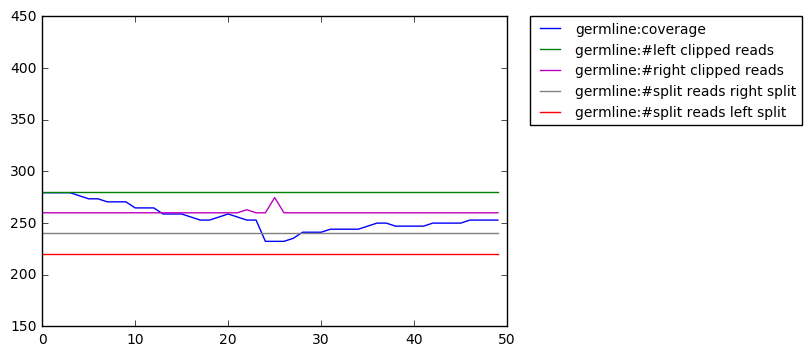

id: 5
Nanopore: DEL_start . DeepSV: DEL_end


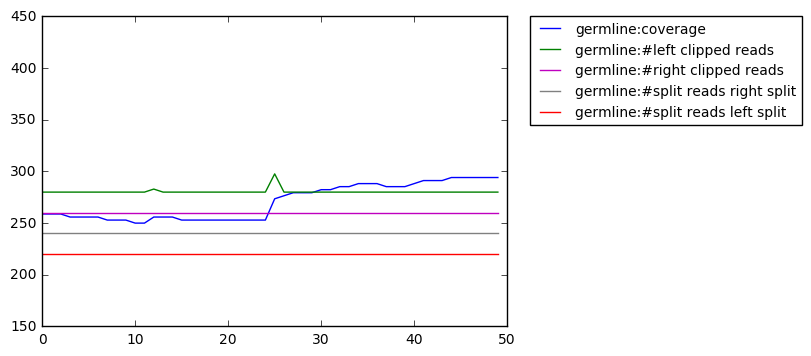

id: 10
Nanopore: DEL_end . DeepSV: DEL_end


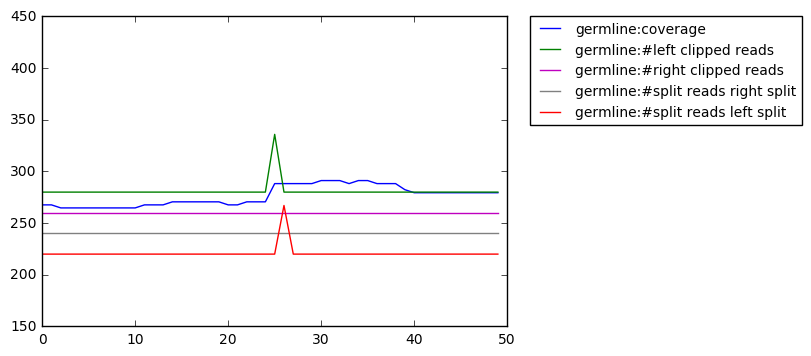

id: 15
Nanopore: DEL_start . DeepSV: DEL_start


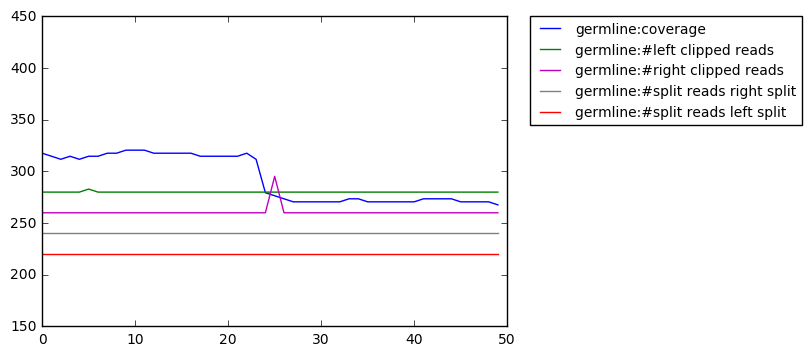

id: 20
Nanopore: DEL_start . DeepSV: DEL_start


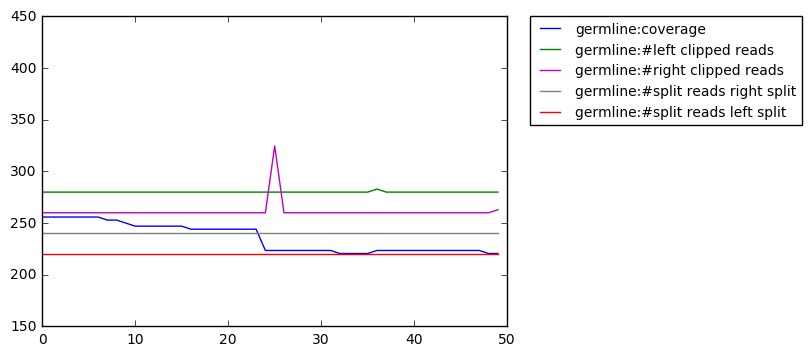

id: 25
Nanopore: DEL_start . DeepSV: DEL_end


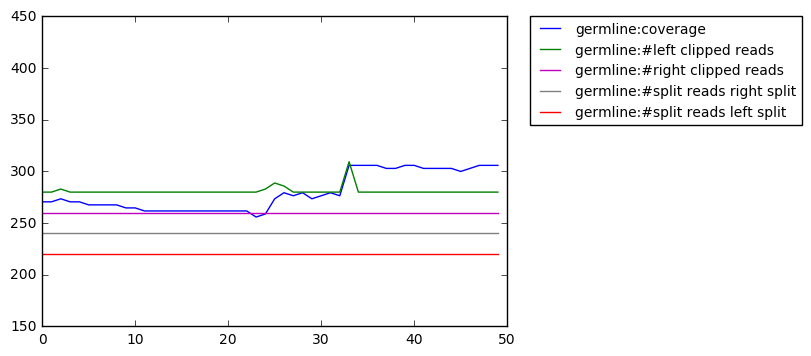

id: 30
Nanopore: DEL_end . DeepSV: DEL_start


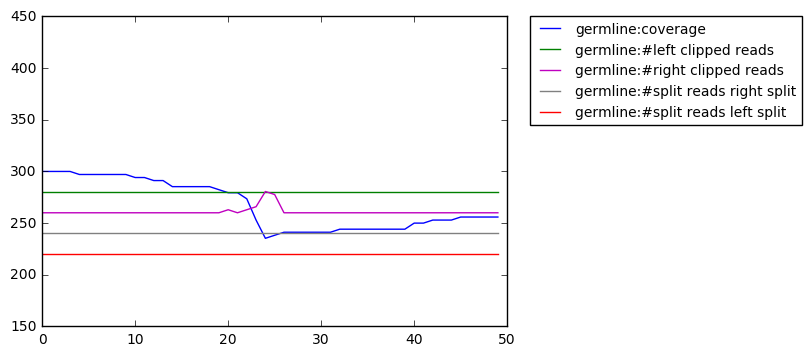

id: 35
Nanopore: DEL_end . DeepSV: DEL_start


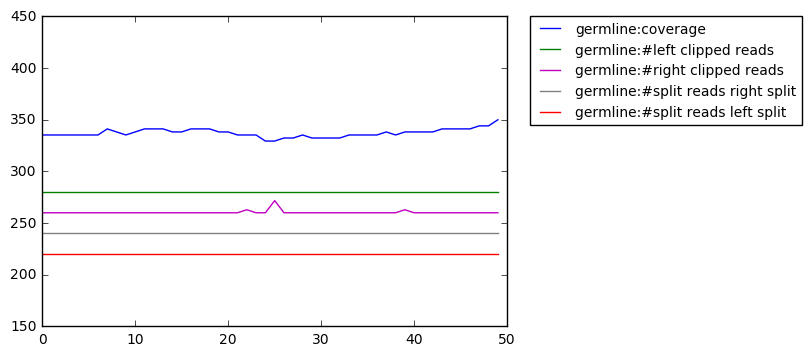

id: 40
Nanopore: DEL_end . DeepSV: DEL_end


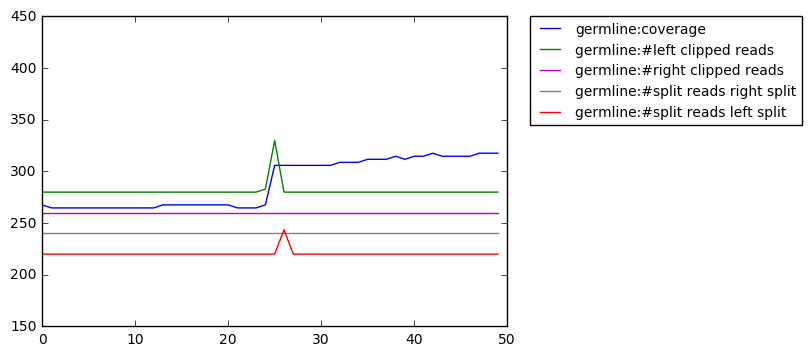

id: 45
Nanopore: DEL_start . DeepSV: DEL_start


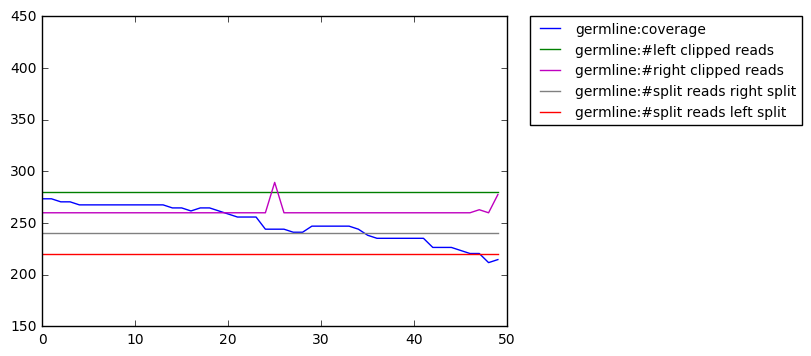

id: 50
Nanopore: DEL_start . DeepSV: DEL_end


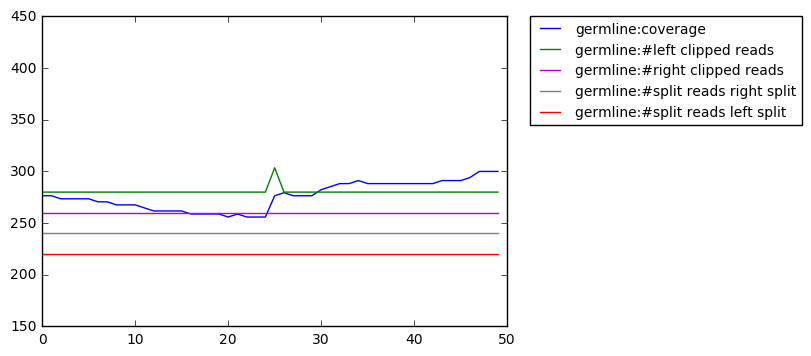

id: 55
Nanopore: DEL_start . DeepSV: DEL_start


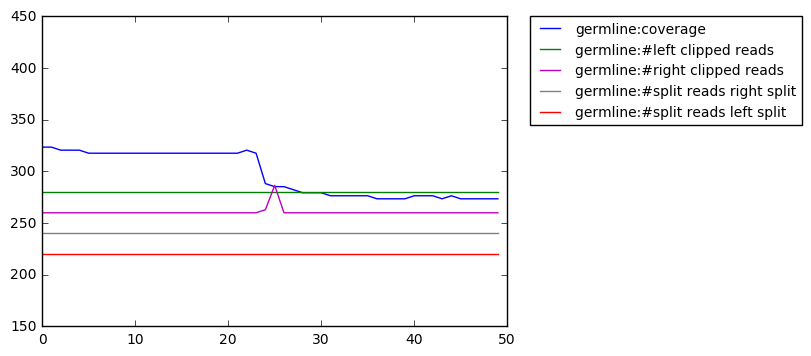

id: 60
Nanopore: DEL_end . DeepSV: DEL_end


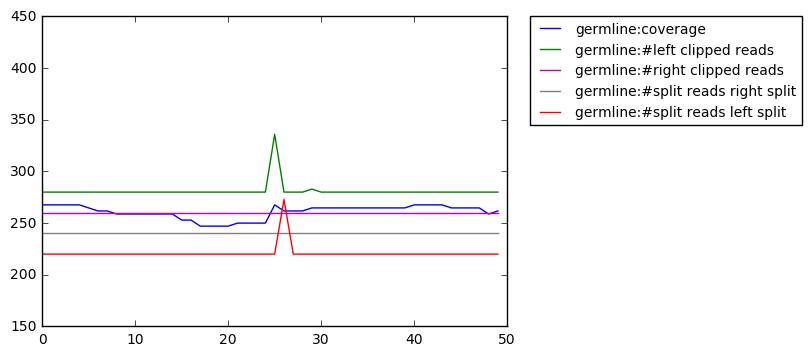

id: 65
Nanopore: DEL_start . DeepSV: DEL_start


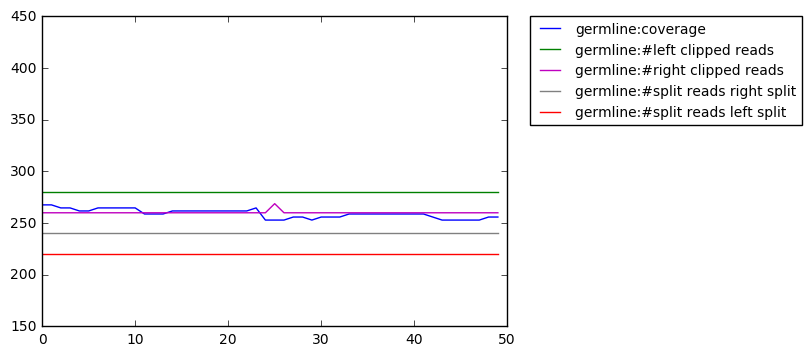

id: 70
Nanopore: DEL_end . DeepSV: DEL_end


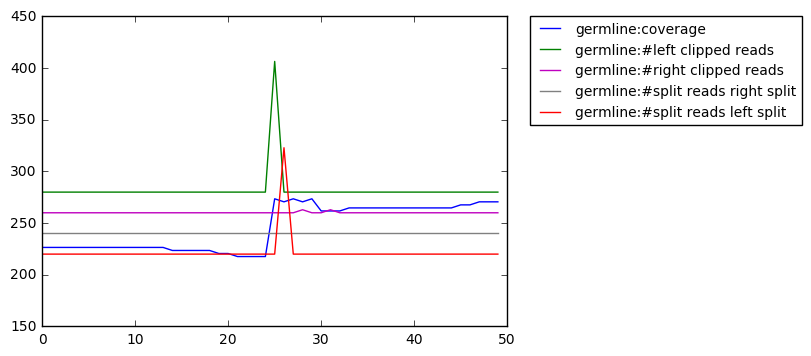

id: 75
Nanopore: DEL_start . DeepSV: DEL_start


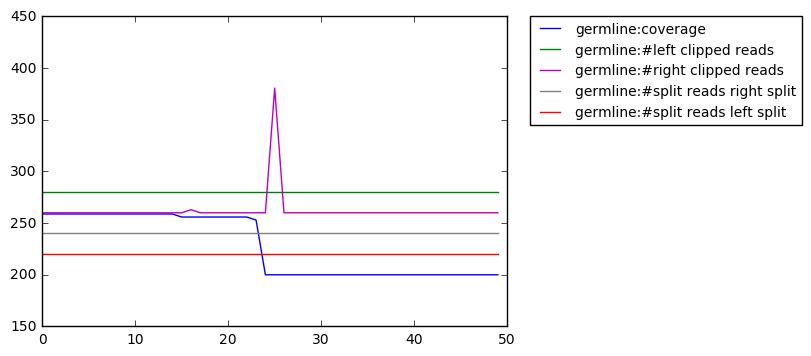

id: 80
Nanopore: DEL_start . DeepSV: DEL_start


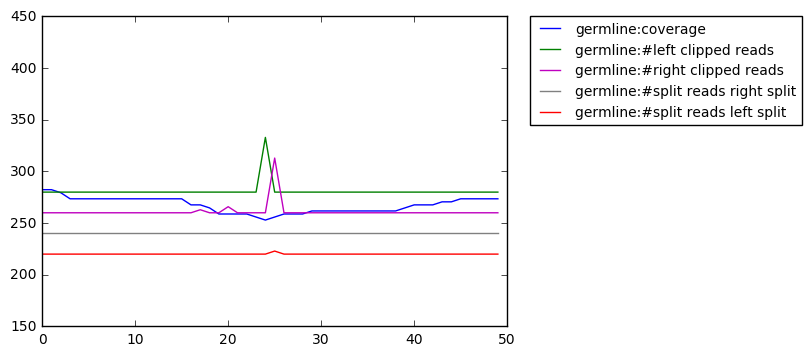

id: 85
Nanopore: DEL_end . DeepSV: DEL_end


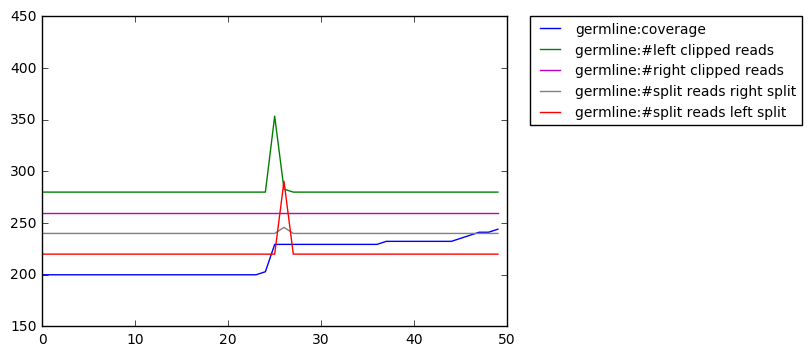

id: 90
Nanopore: DEL_end . DeepSV: DEL_end


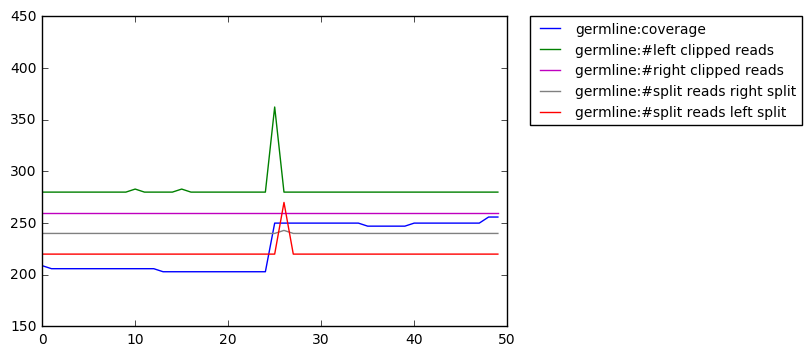

id: 95
Nanopore: DEL_end . DeepSV: DEL_start


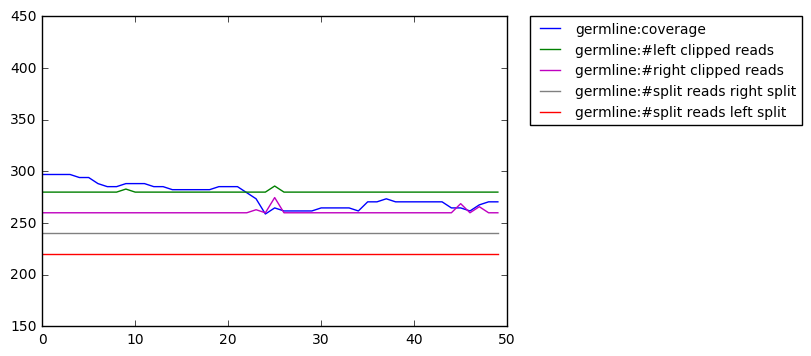

id: 100
Nanopore: DEL_start . DeepSV: DEL_end


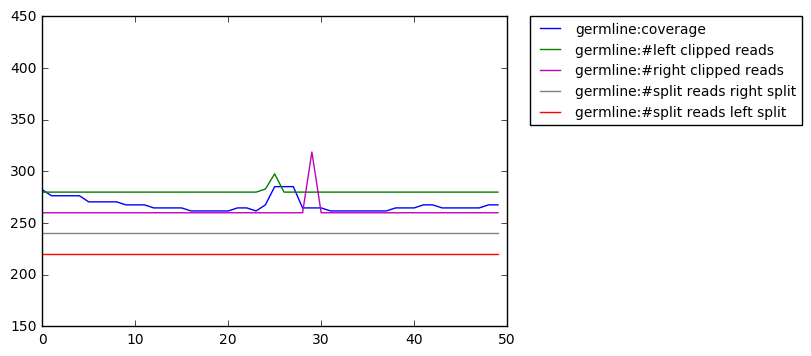

id: 105
Nanopore: DEL_end . DeepSV: DEL_end


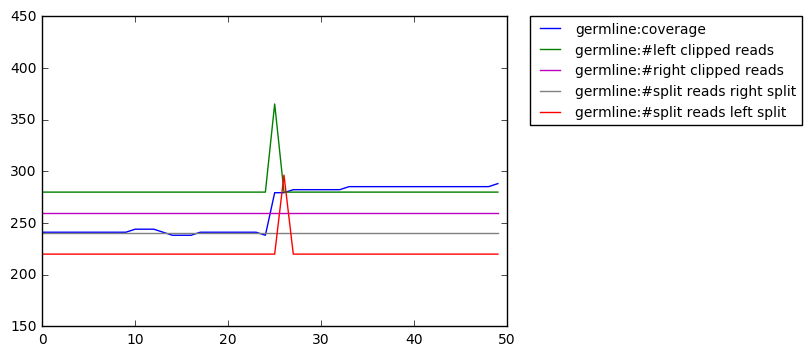

id: 110
Nanopore: DEL_start . DeepSV: DEL_start


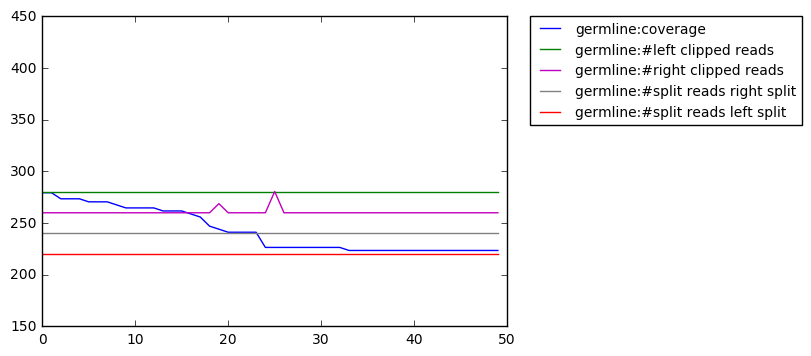

id: 115
Nanopore: DEL_end . DeepSV: DEL_end


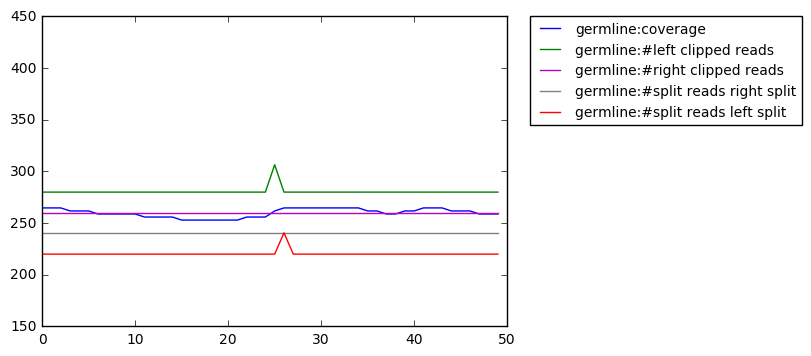

id: 120
Nanopore: DEL_start . DeepSV: DEL_start


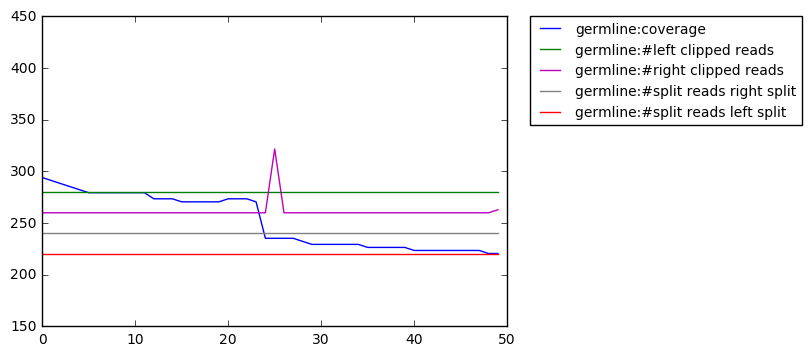

id: 125
Nanopore: DEL_start . DeepSV: DEL_start


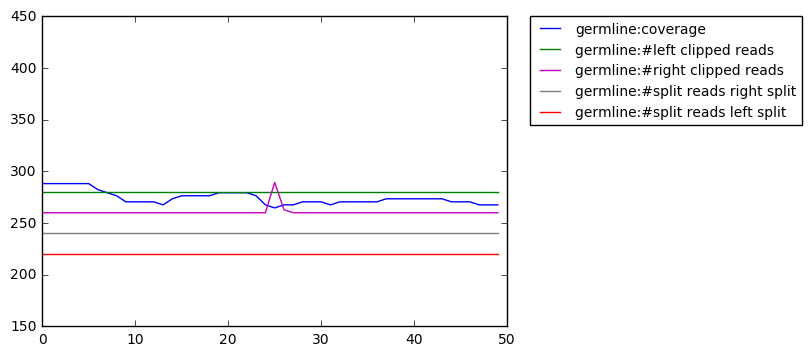

id: 130
Nanopore: DEL_start . DeepSV: noSV


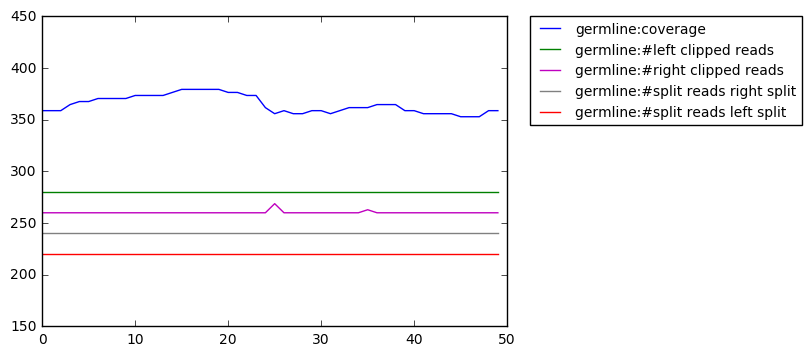

id: 135
Nanopore: DEL_end . DeepSV: DEL_end


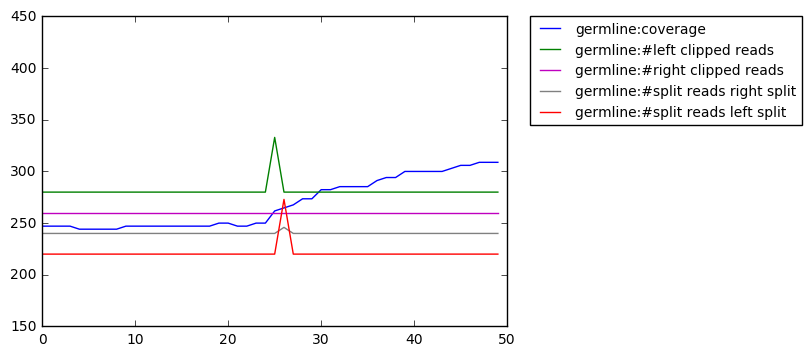

id: 140
Nanopore: DEL_end . DeepSV: DEL_start


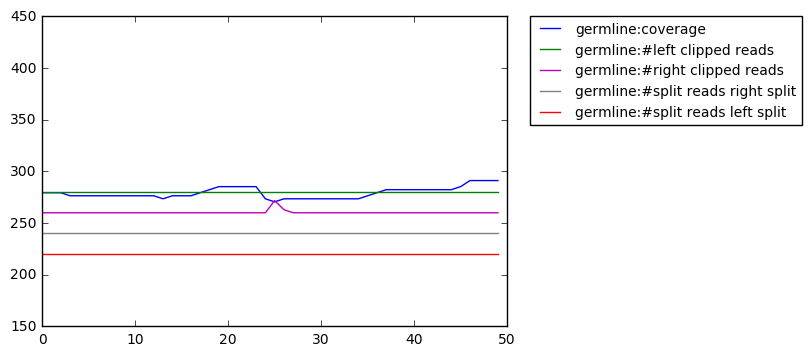

id: 145
Nanopore: DEL_end . DeepSV: DEL_start


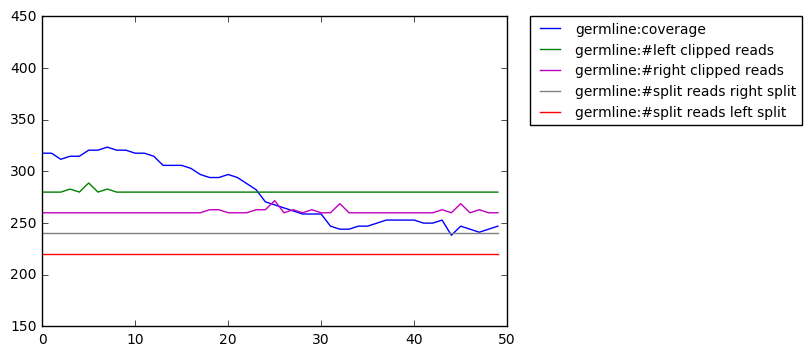

id: 150
Nanopore: DEL_start . DeepSV: DEL_start


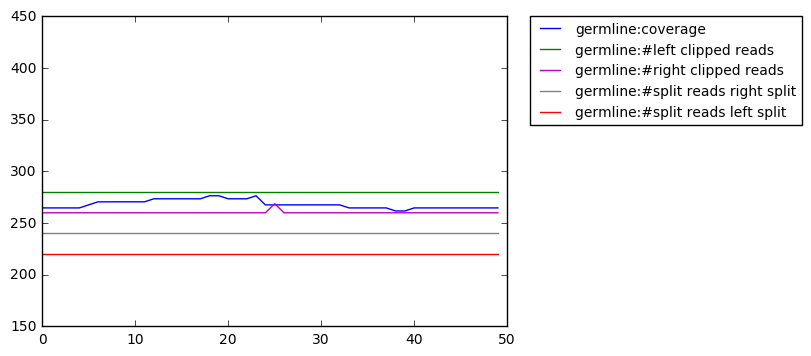

id: 155
Nanopore: DEL_end . DeepSV: DEL_start


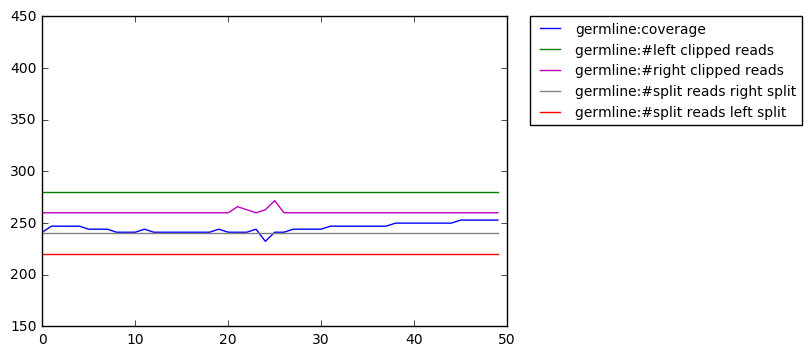

id: 160
Nanopore: DEL_start . DeepSV: DEL_end


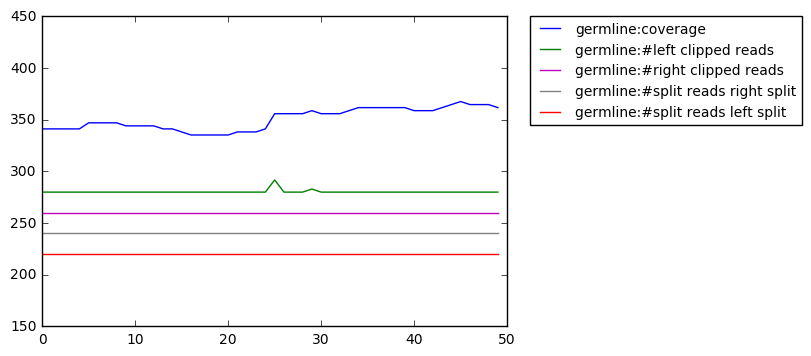

id: 165
Nanopore: DEL_start . DeepSV: DEL_end


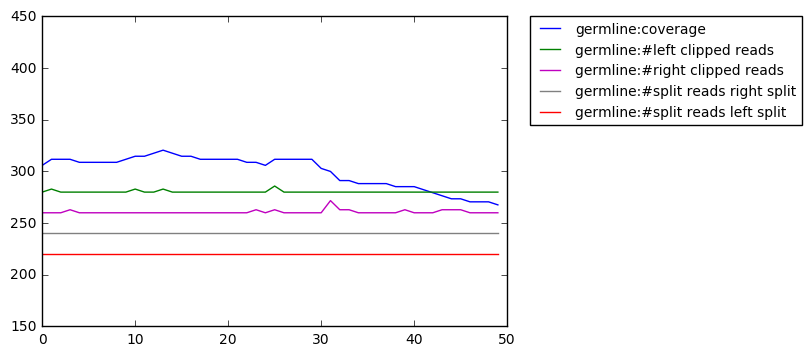

id: 170
Nanopore: DEL_start . DeepSV: DEL_start


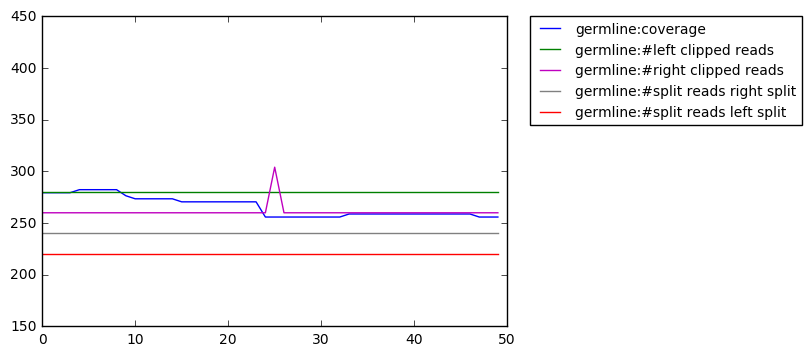

id: 175
Nanopore: DEL_start . DeepSV: DEL_end


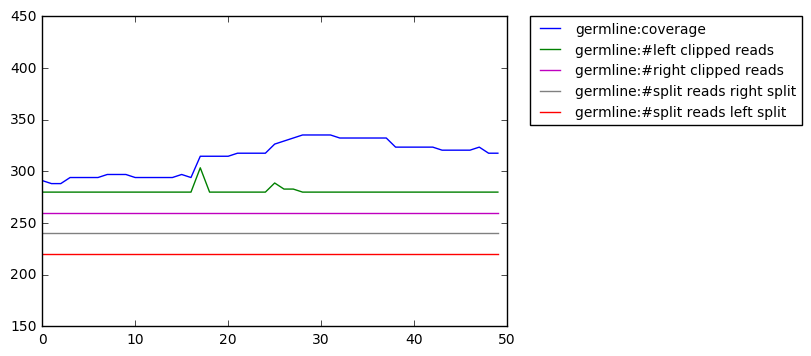

id: 180
Nanopore: DEL_end . DeepSV: DEL_start


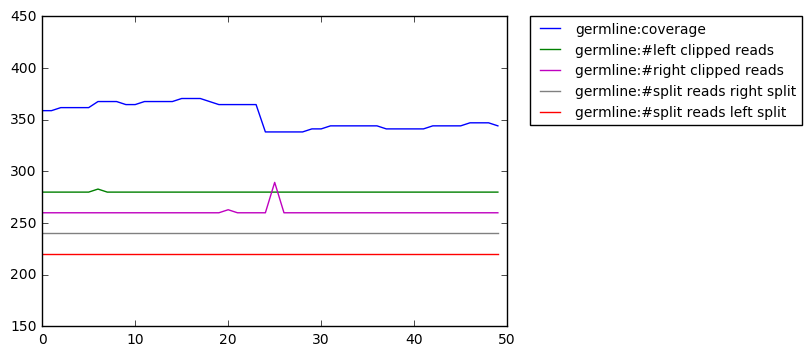

id: 185
Nanopore: DEL_start . DeepSV: DEL_start


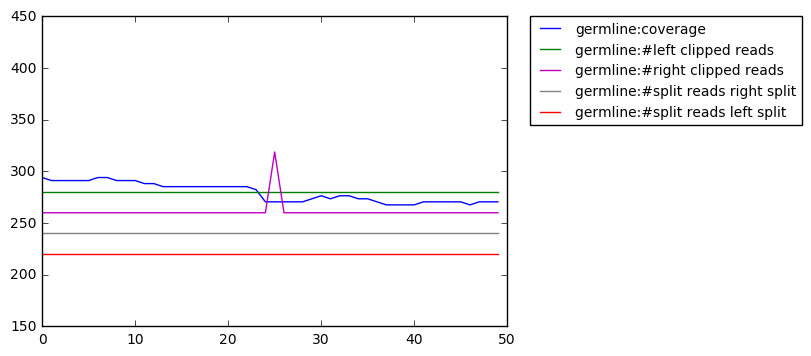

id: 190
Nanopore: DEL_end . DeepSV: DEL_end


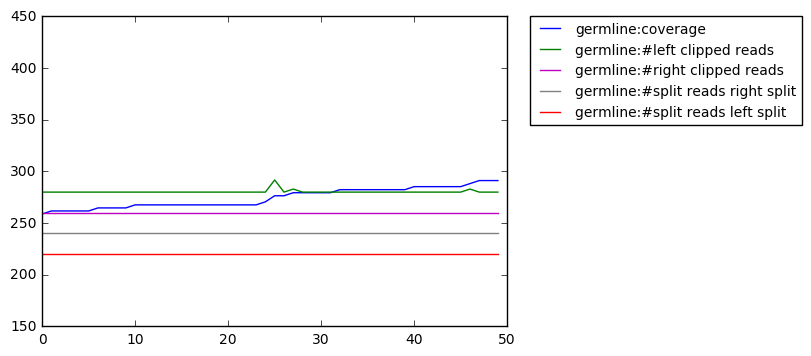

id: 195
Nanopore: DEL_start . DeepSV: DEL_start


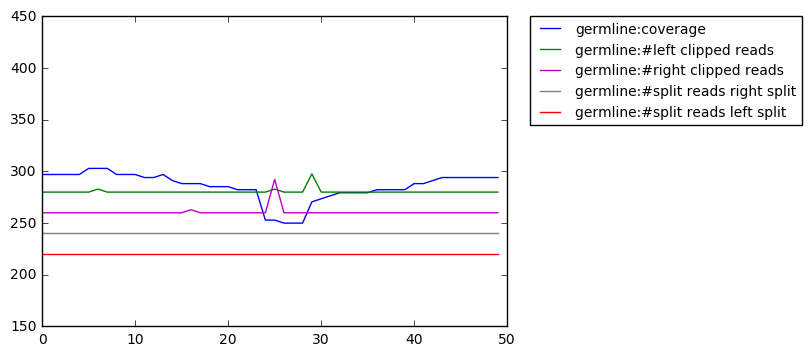

id: 200
Nanopore: DEL_end . DeepSV: DEL_start


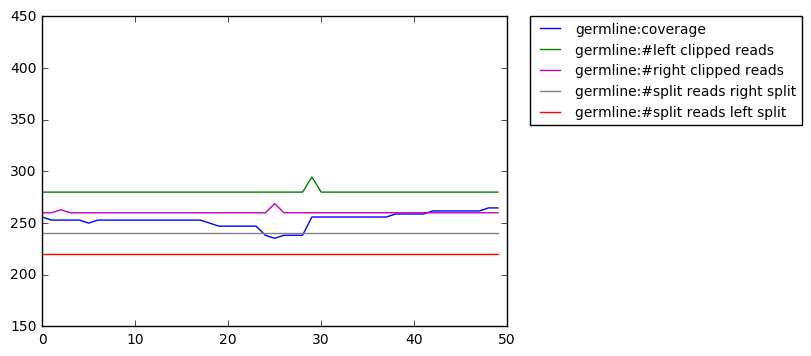

id: 205
Nanopore: DEL_start . DeepSV: DEL_start


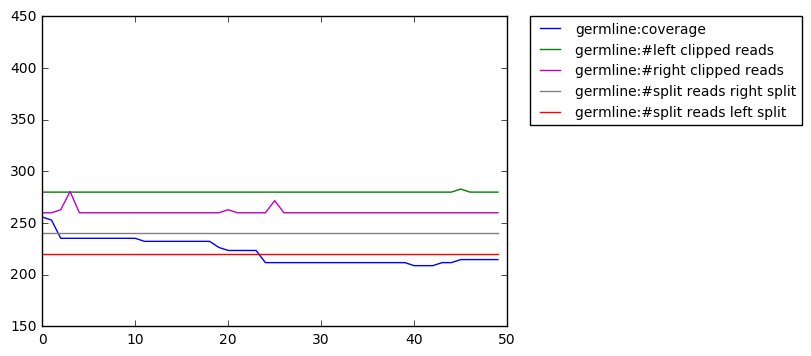

id: 210
Nanopore: DEL_end . DeepSV: noSV


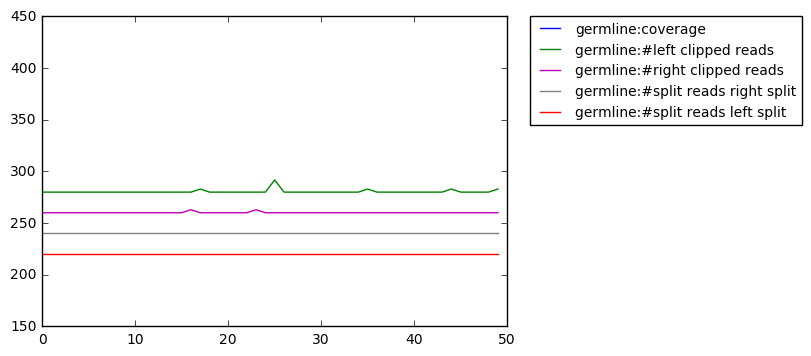

id: 215
Nanopore: DEL_end . DeepSV: DEL_start


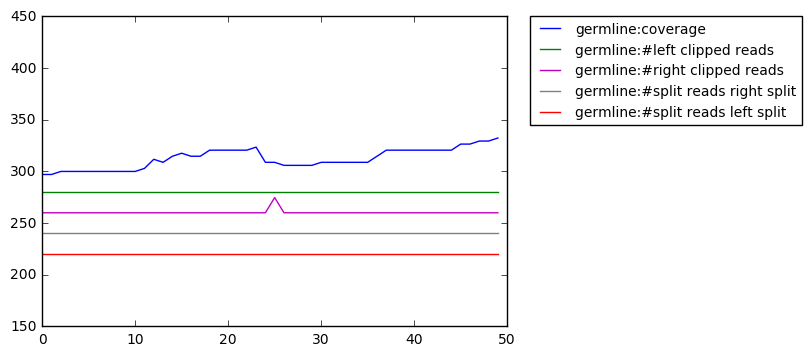

id: 220
Nanopore: DEL_start . DeepSV: DEL_start


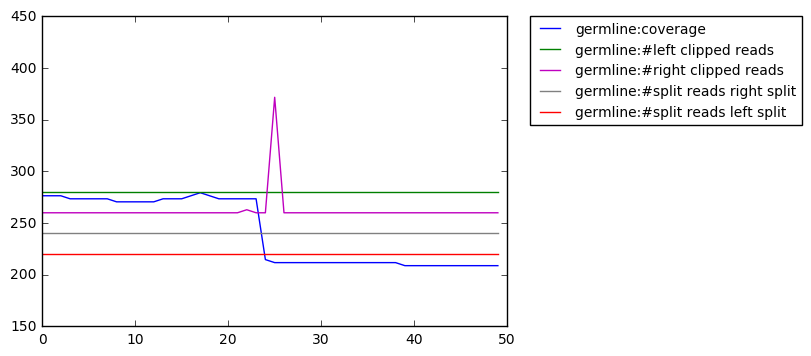

id: 225
Nanopore: DEL_start . DeepSV: DEL_end


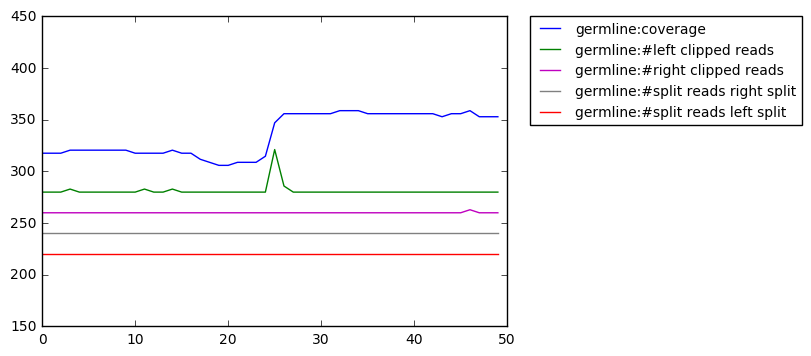

id: 230
Nanopore: DEL_start . DeepSV: DEL_end


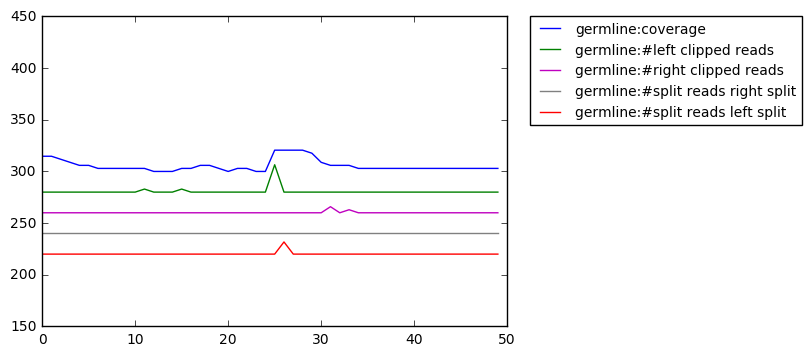

id: 235
Nanopore: DEL_end . DeepSV: DEL_start


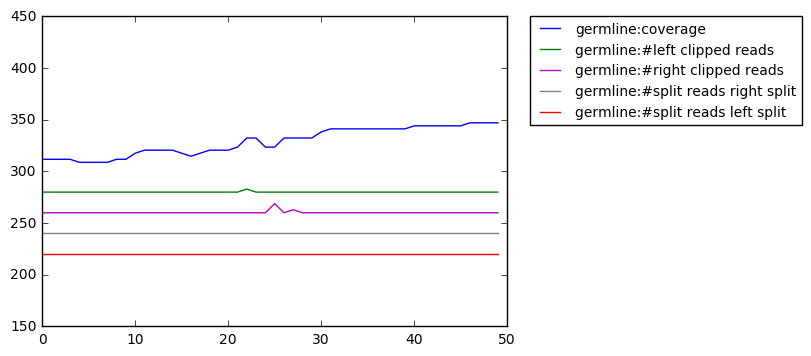

id: 240
Nanopore: DEL_end . DeepSV: DEL_end


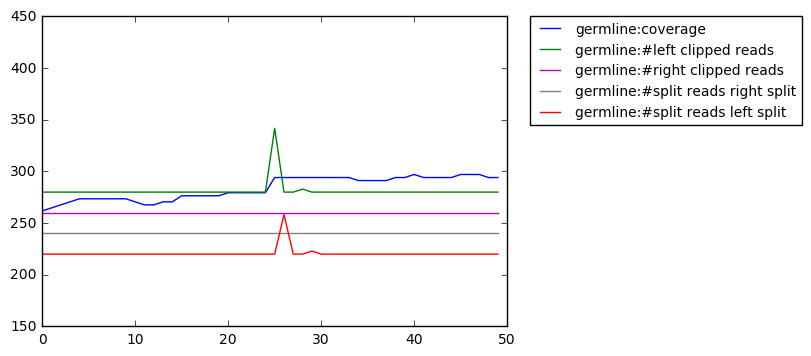

id: 245
Nanopore: DEL_end . DeepSV: DEL_end


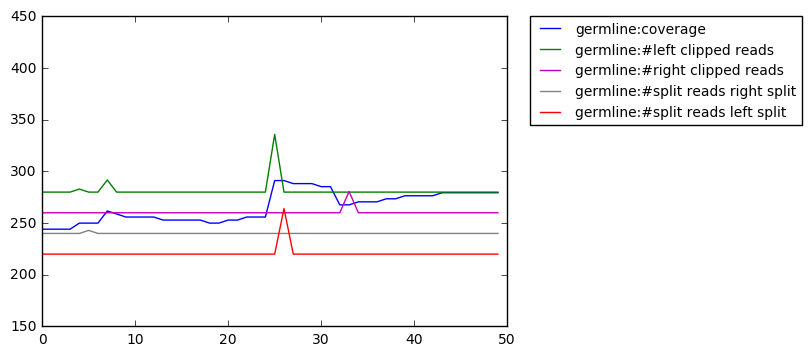

id: 250
Nanopore: DEL_start . DeepSV: DEL_start


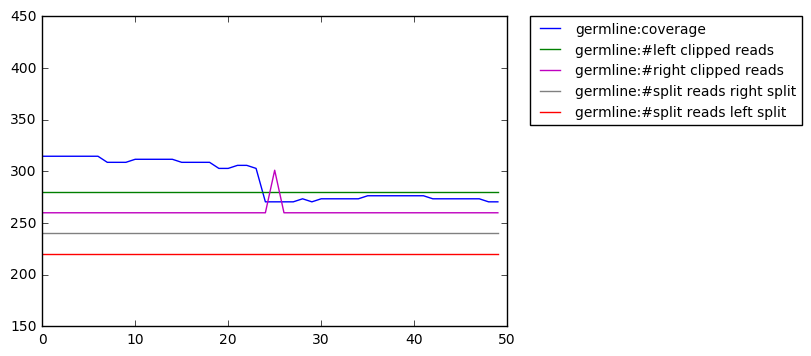

id: 255
Nanopore: DEL_end . DeepSV: DEL_end


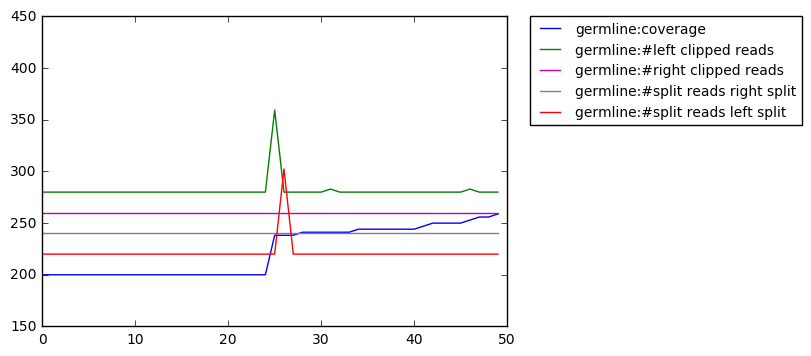

id: 260
Nanopore: DEL_start . DeepSV: DEL_end


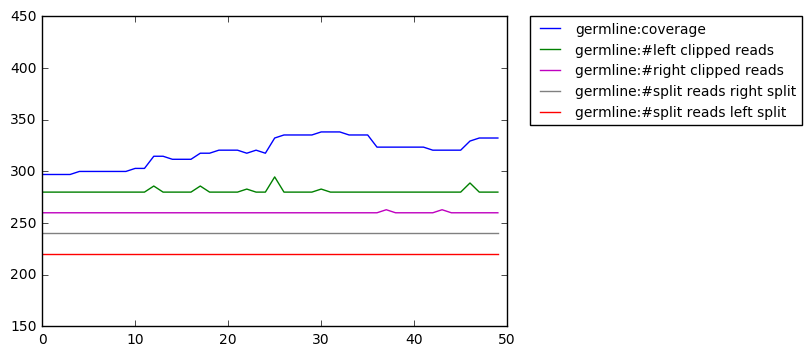

id: 265
Nanopore: DEL_end . DeepSV: DEL_end


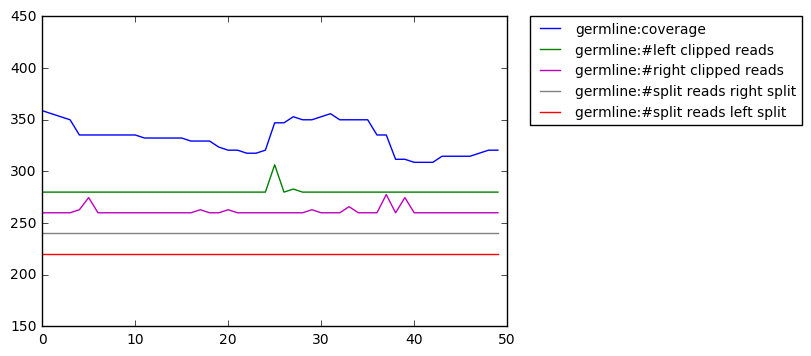

id: 270
Nanopore: DEL_start . DeepSV: DEL_end


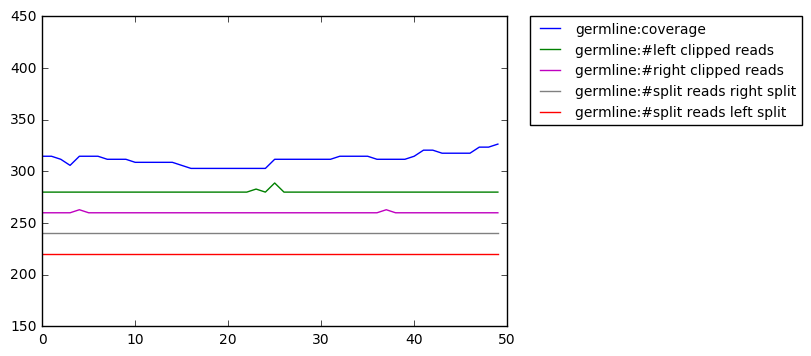

id: 275
Nanopore: DEL_start . DeepSV: DEL_start


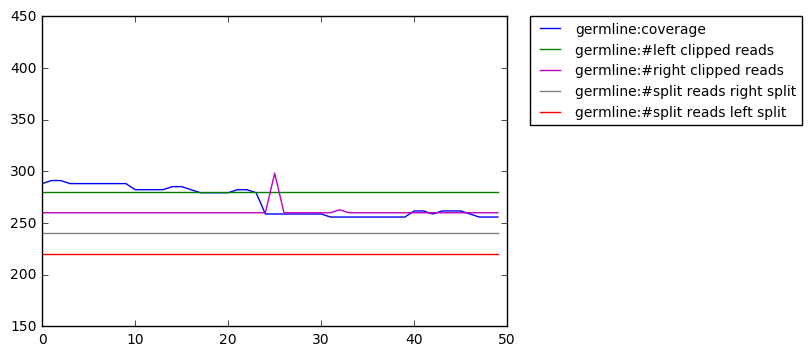

id: 280
Nanopore: DEL_end . DeepSV: DEL_end


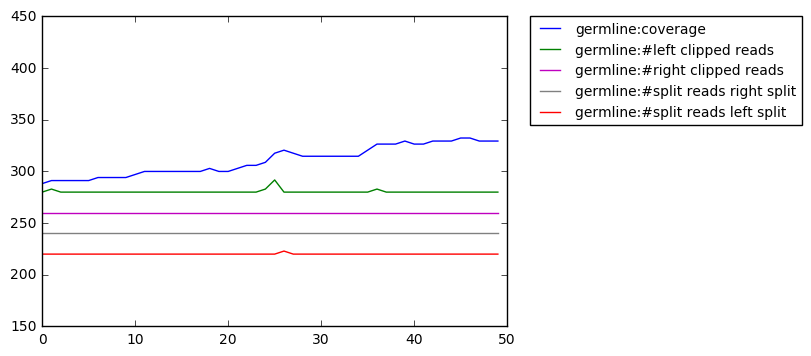

id: 285
Nanopore: DEL_end . DeepSV: DEL_end


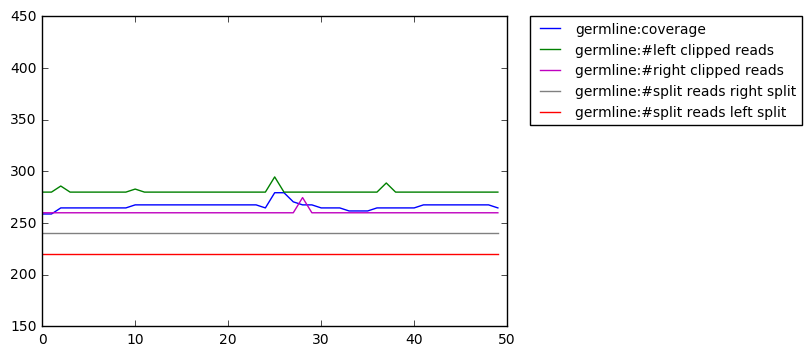

id: 290
Nanopore: DEL_start . DeepSV: DEL_start


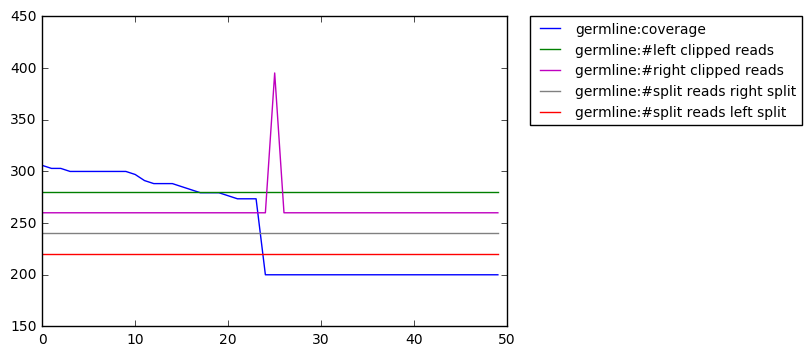

id: 295
Nanopore: DEL_start . DeepSV: DEL_end


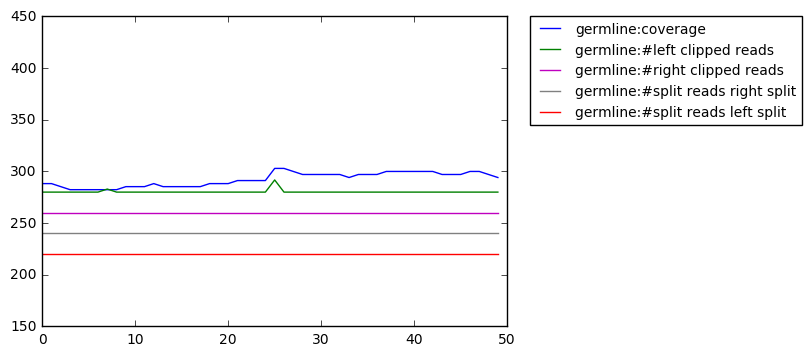

id: 300
Nanopore: DEL_end . DeepSV: DEL_start


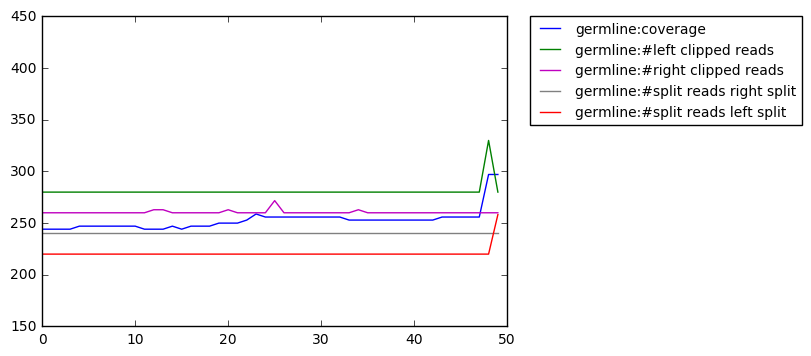

id: 305
Nanopore: DEL_start . DeepSV: DEL_start


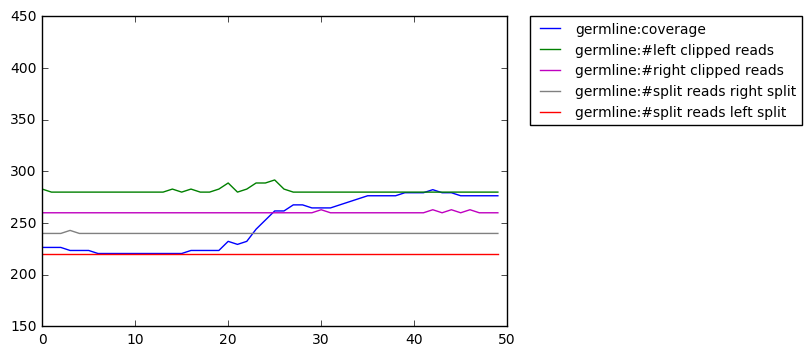

id: 310
Nanopore: DEL_start . DeepSV: DEL_end


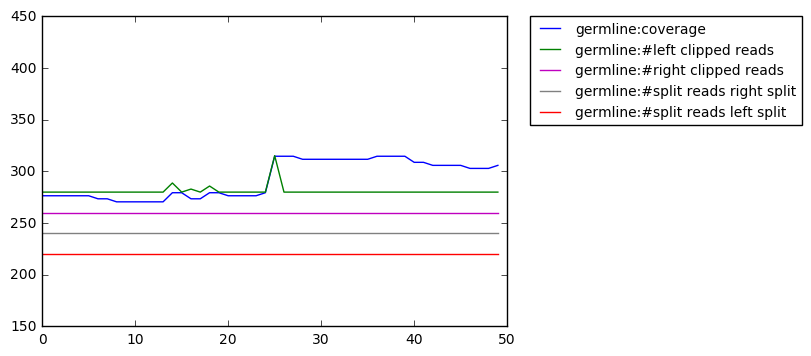

id: 315
Nanopore: DEL_start . DeepSV: noSV


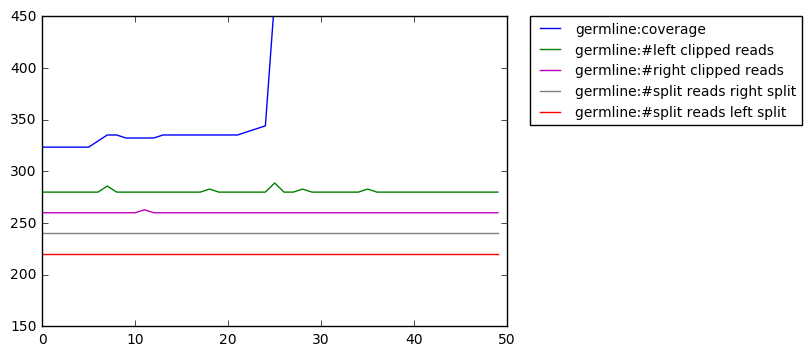

id: 320
Nanopore: DEL_start . DeepSV: DEL_end


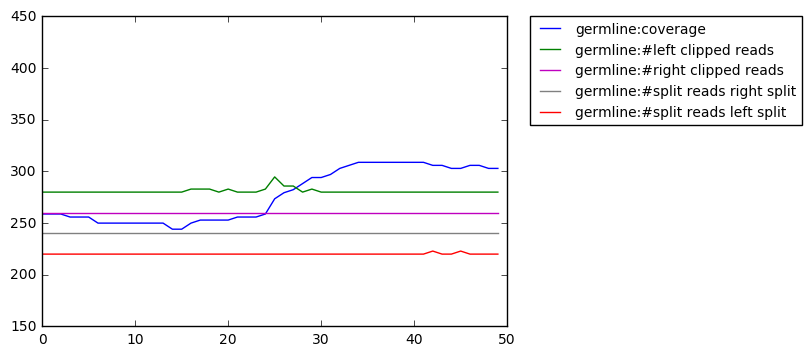

id: 325
Nanopore: DEL_end . DeepSV: DEL_end


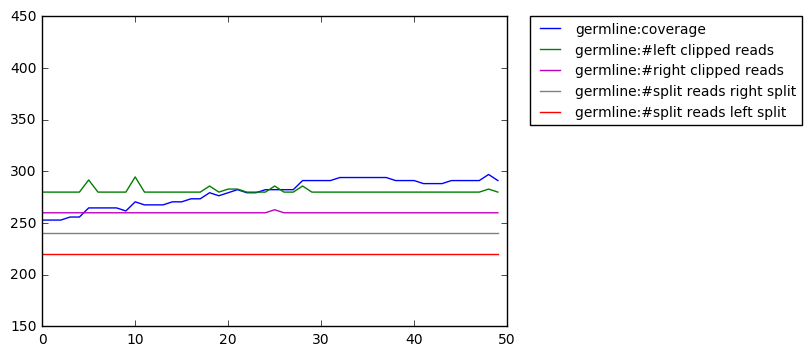

id: 330
Nanopore: DEL_start . DeepSV: DEL_end


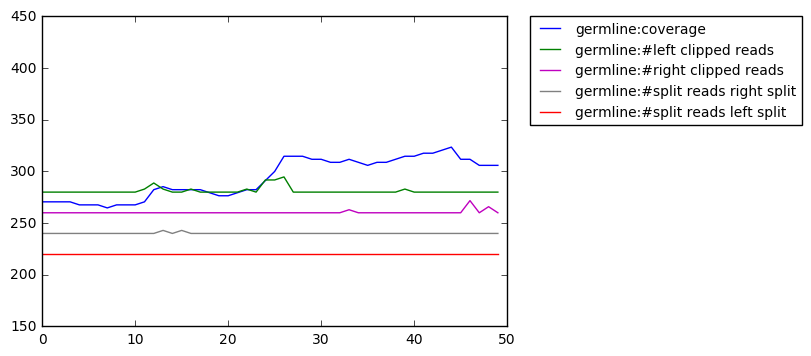

id: 335
Nanopore: DEL_start . DeepSV: DEL_end


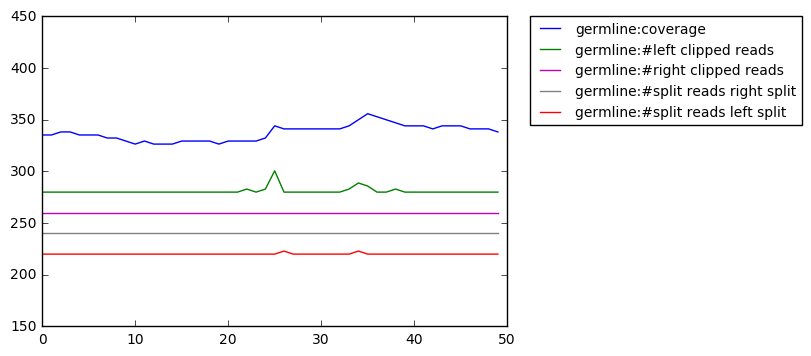

id: 340
Nanopore: DEL_start . DeepSV: DEL_start


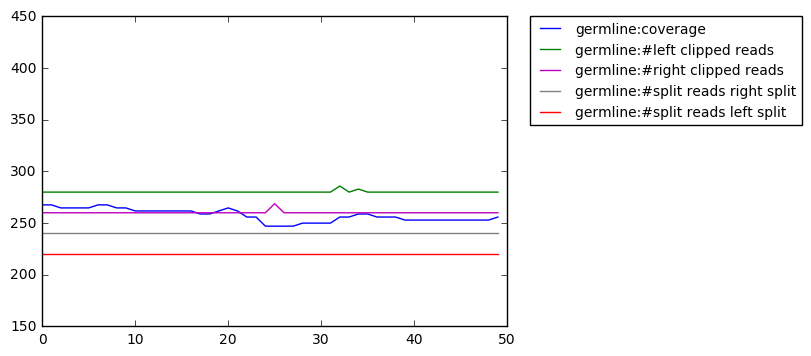

id: 345
Nanopore: DEL_start . DeepSV: DEL_start


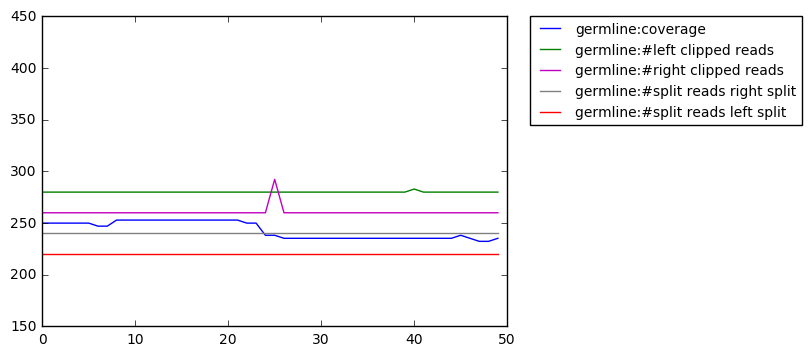

id: 350
Nanopore: DEL_end . DeepSV: DEL_end


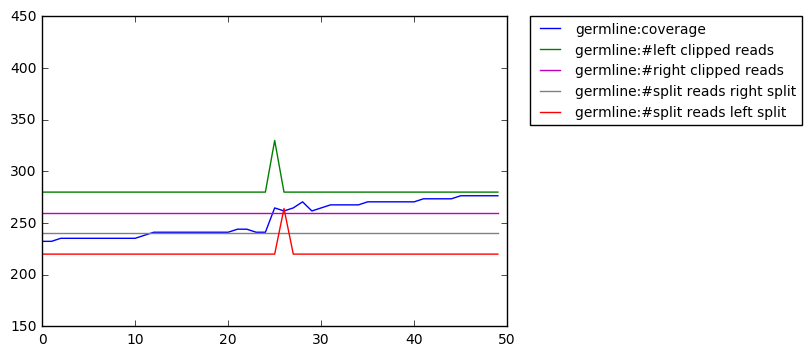

id: 355
Nanopore: DEL_end . DeepSV: DEL_start


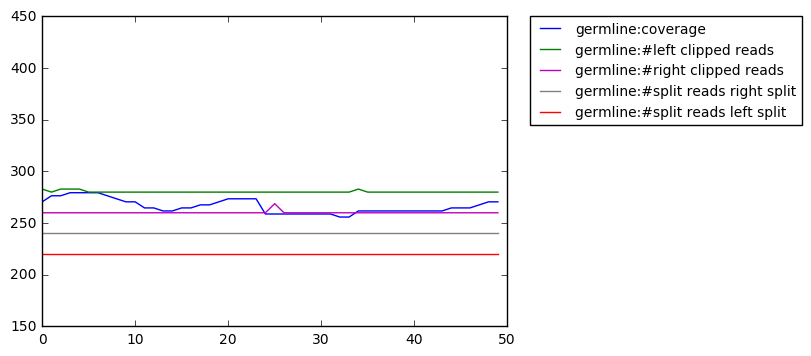

id: 360
Nanopore: DEL_end . DeepSV: DEL_start


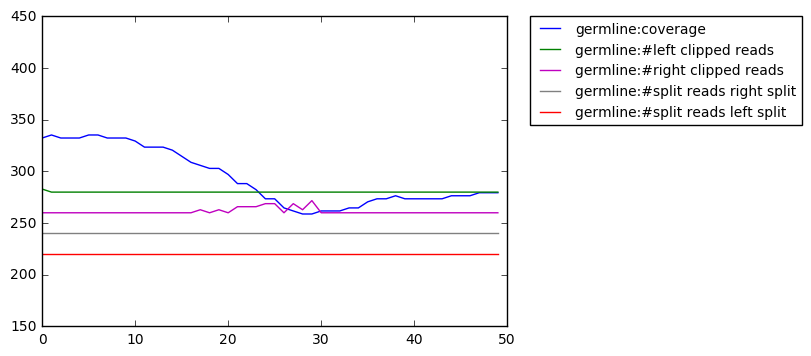

id: 365
Nanopore: DEL_start . DeepSV: DEL_start


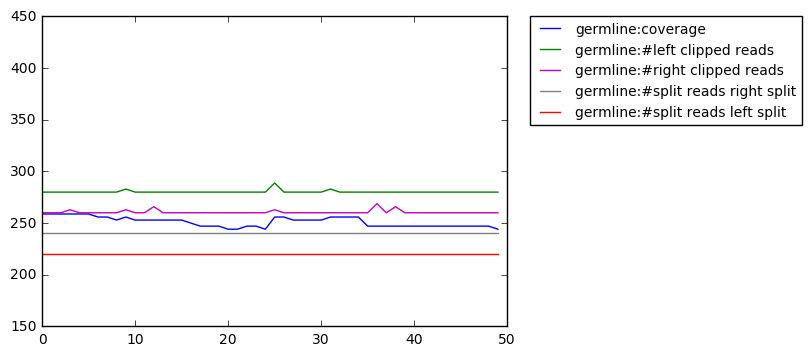

id: 370
Nanopore: DEL_end . DeepSV: DEL_start


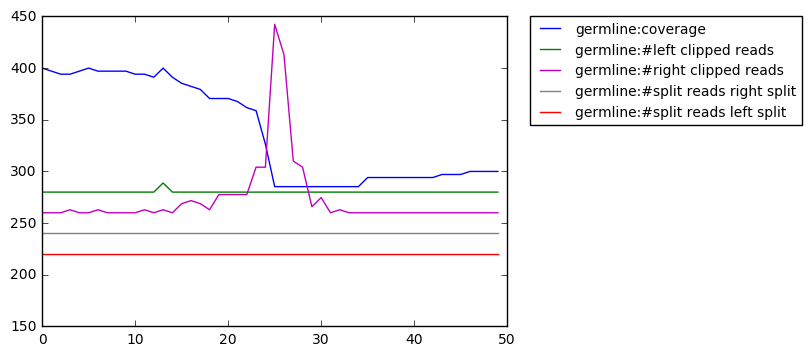

id: 375
Nanopore: DEL_start . DeepSV: noSV


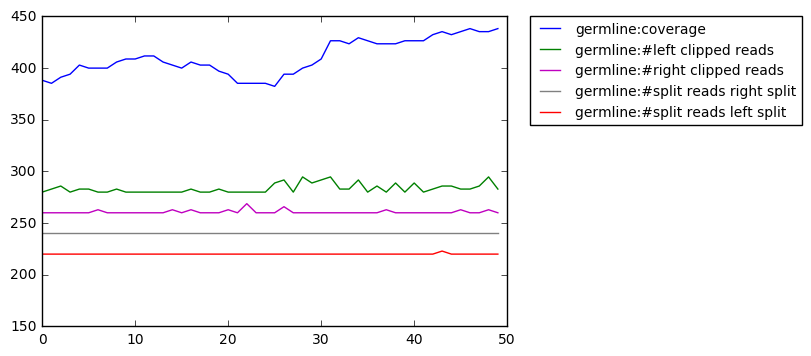

id: 380
Nanopore: DEL_end . DeepSV: DEL_start


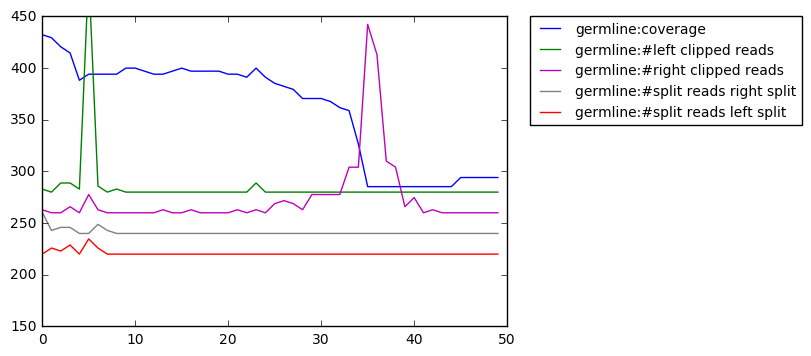

id: 385
Nanopore: DEL_end . DeepSV: DEL_start


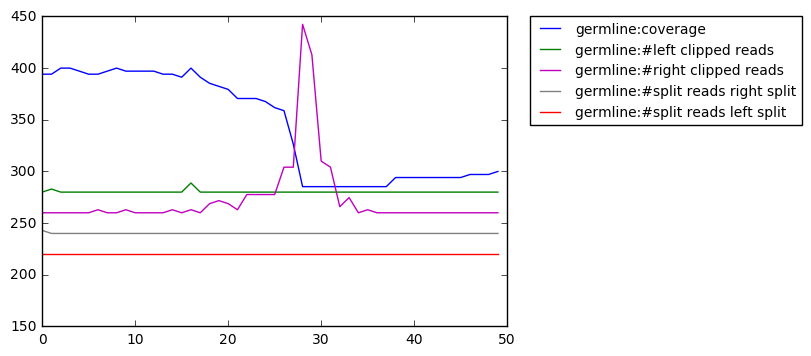

id: 390
Nanopore: DEL_end . DeepSV: DEL_start


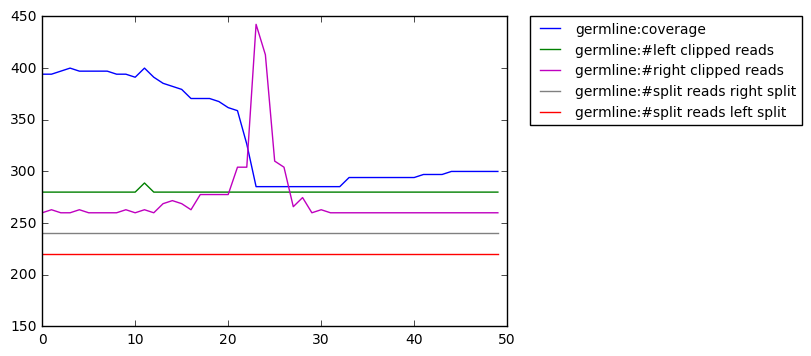

id: 395
Nanopore: DEL_end . DeepSV: DEL_end


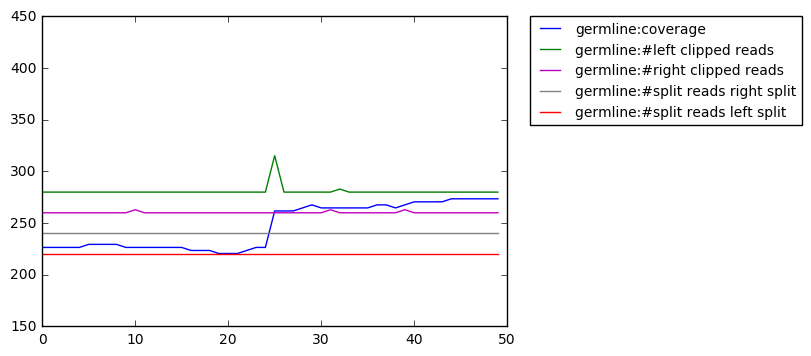

id: 400
Nanopore: DEL_start . DeepSV: DEL_start


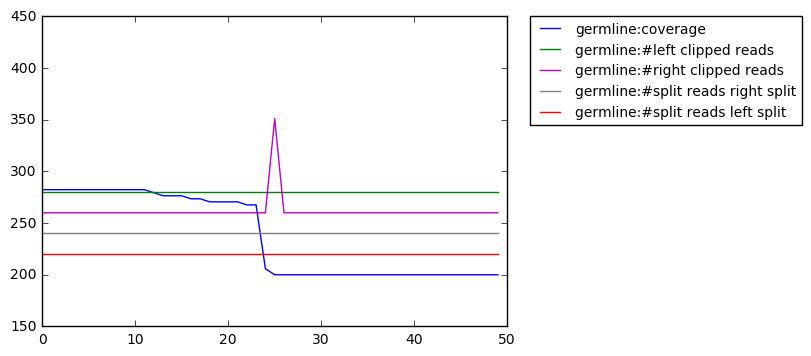

id: 405
Nanopore: DEL_start . DeepSV: DEL_end


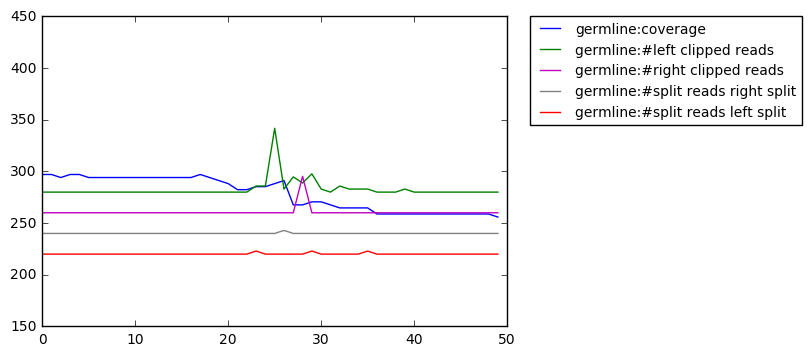

id: 410
Nanopore: DEL_end . DeepSV: DEL_end


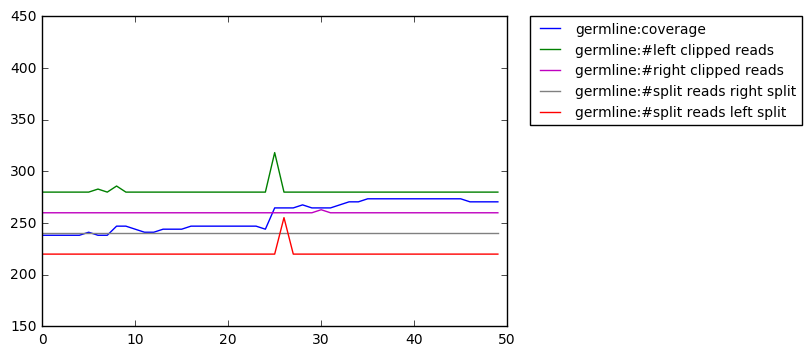

id: 415
Nanopore: DEL_end . DeepSV: DEL_end


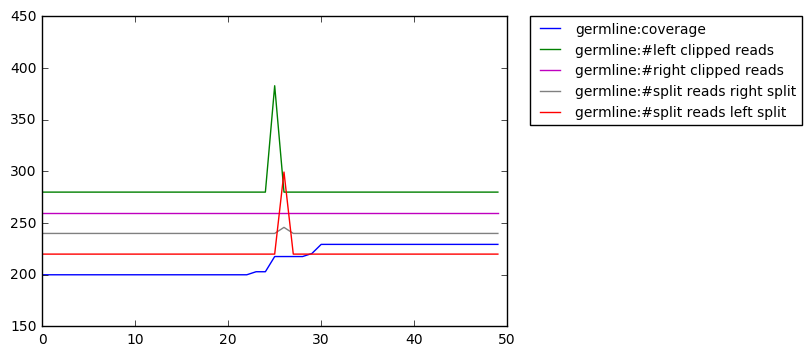

id: 420
Nanopore: DEL_start . DeepSV: DEL_start


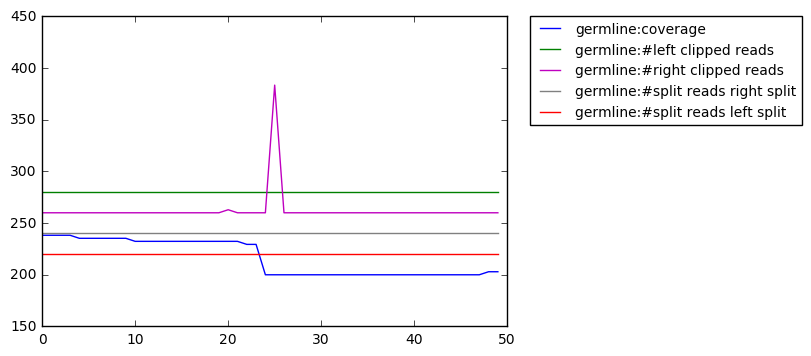

id: 425
Nanopore: DEL_start . DeepSV: DEL_start


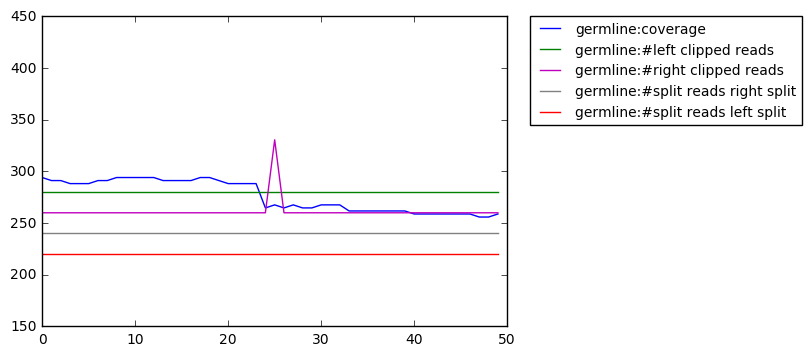

id: 430
Nanopore: DEL_end . DeepSV: DEL_end


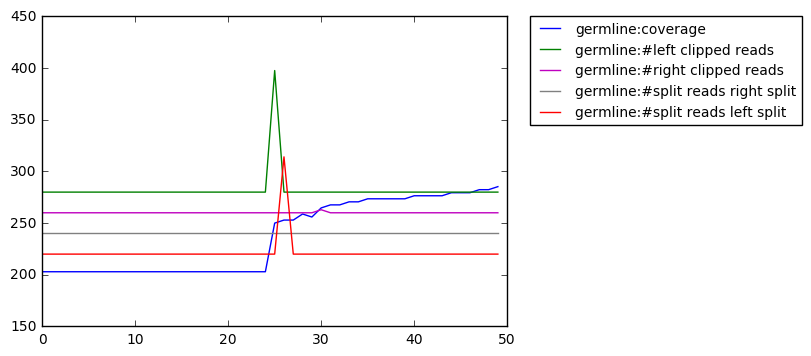

id: 435
Nanopore: DEL_end . DeepSV: DEL_end


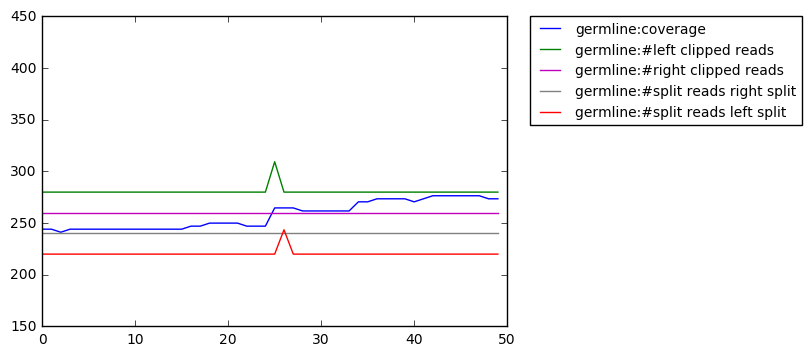

id: 440
Nanopore: DEL_start . DeepSV: DEL_start


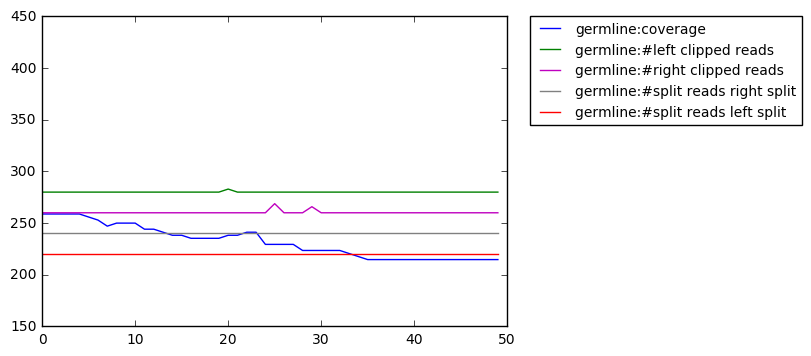

id: 445
Nanopore: DEL_end . DeepSV: DEL_end


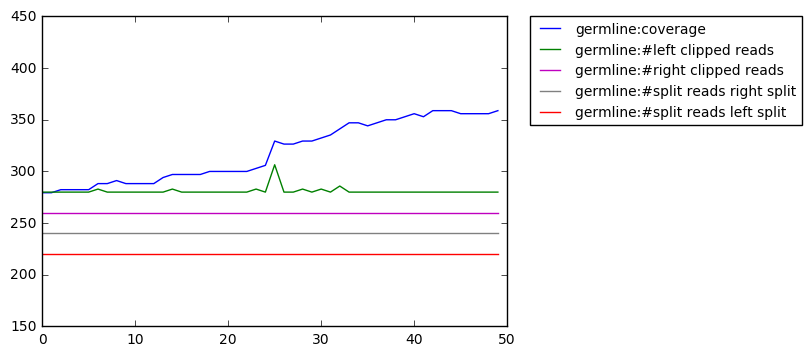

id: 450
Nanopore: DEL_start . DeepSV: DEL_end


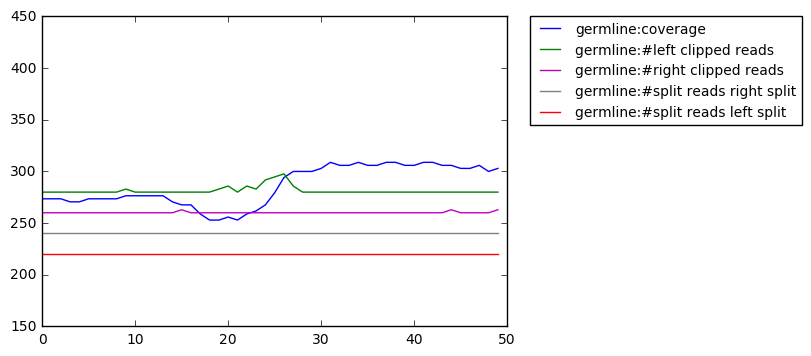

id: 455
Nanopore: DEL_end . DeepSV: DEL_start


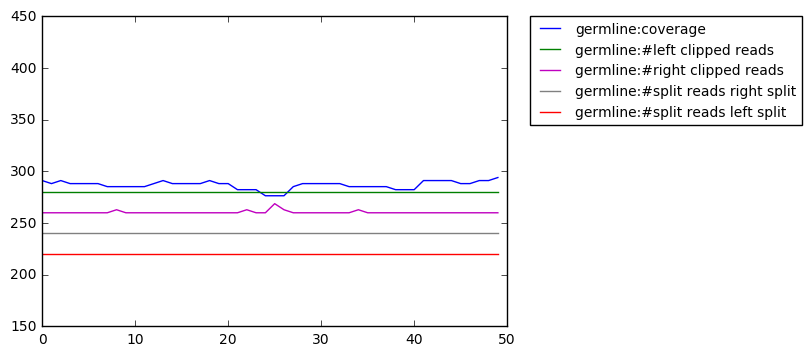

id: 460
Nanopore: DEL_end . DeepSV: DEL_start


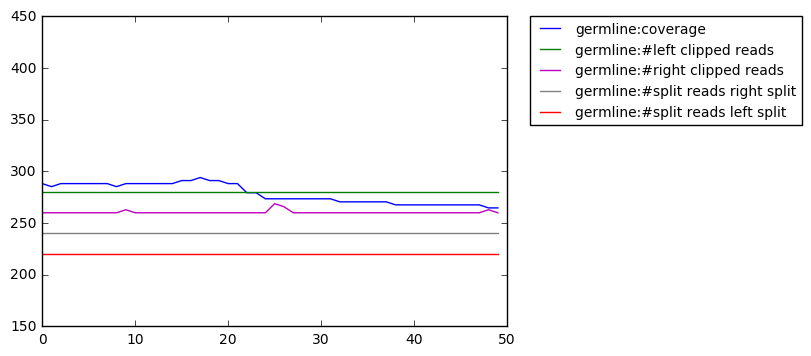

id: 465
Nanopore: DEL_end . DeepSV: DEL_start


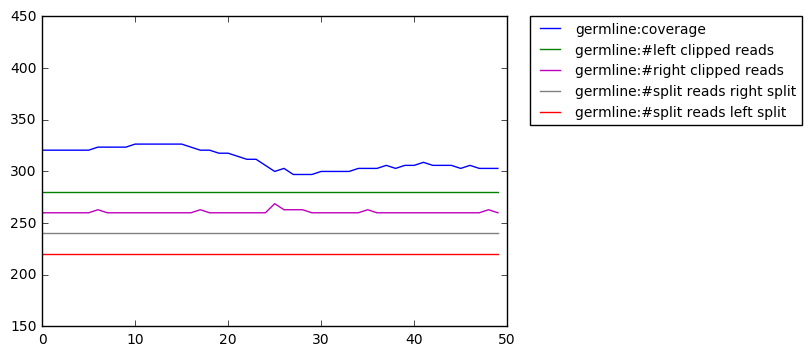

id: 470
Nanopore: DEL_end . DeepSV: DEL_start


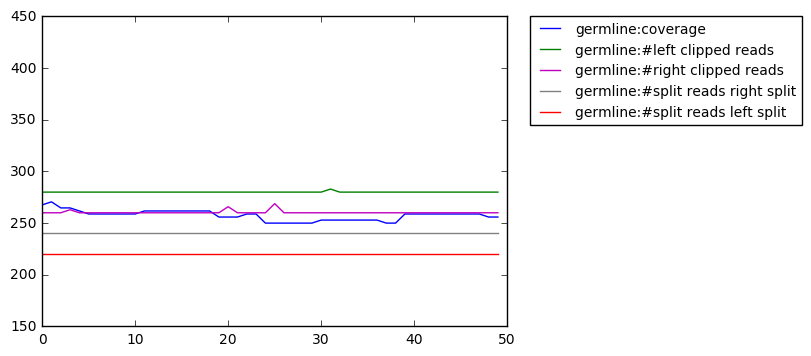

id: 475
Nanopore: DEL_start . DeepSV: DEL_start


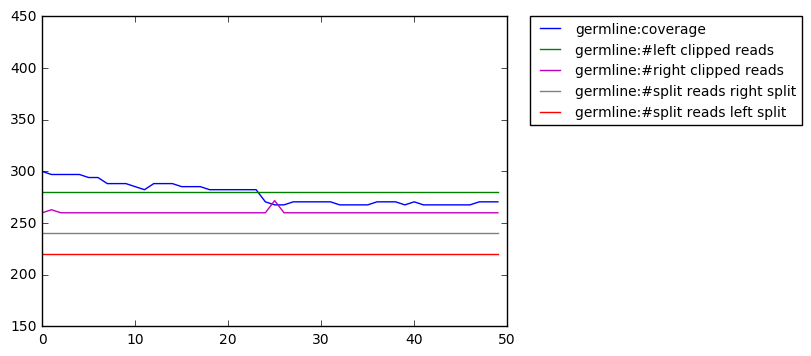

id: 480
Nanopore: DEL_end . DeepSV: DEL_end


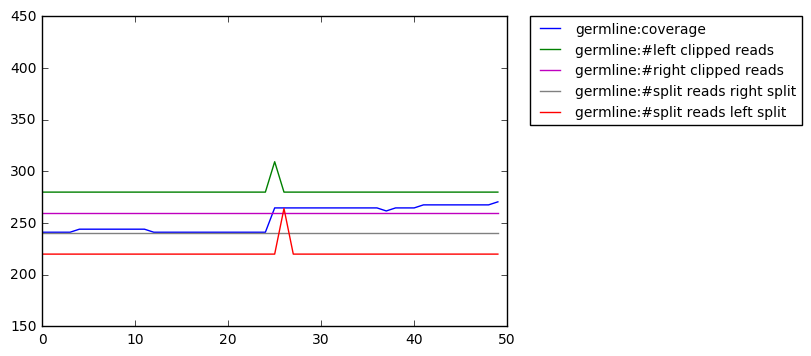

id: 485
Nanopore: DEL_start . DeepSV: DEL_start


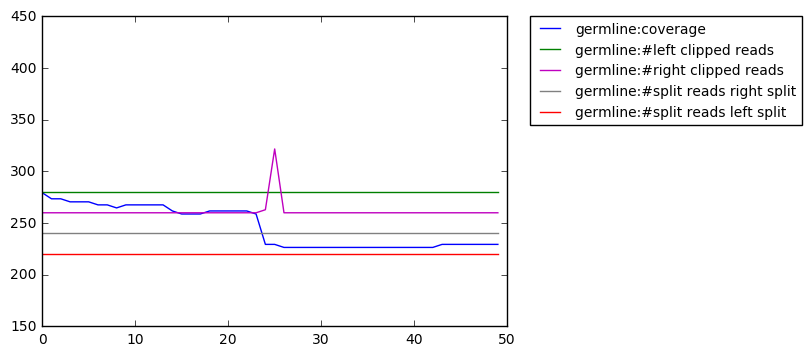

id: 490
Nanopore: DEL_start . DeepSV: DEL_start


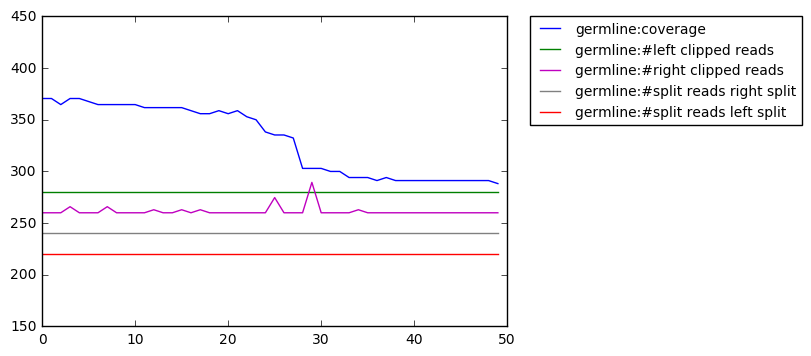

id: 495
Nanopore: DEL_end . DeepSV: DEL_end


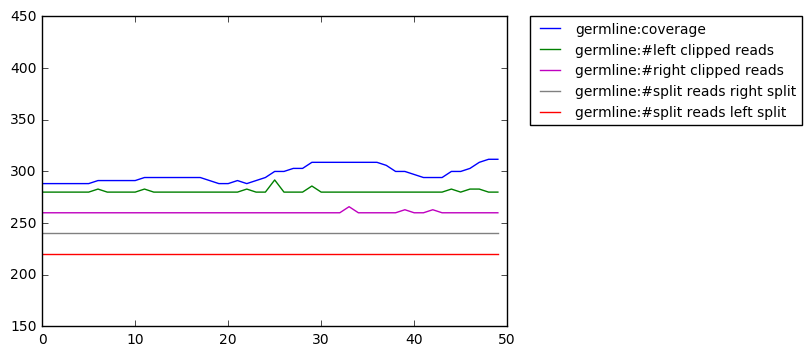

In [72]:
start_window = 0
n_windows = 500
plot_channels(start_window, n_windows)

id: 3000
Nanopore: noSV . DeepSV: DEL_start


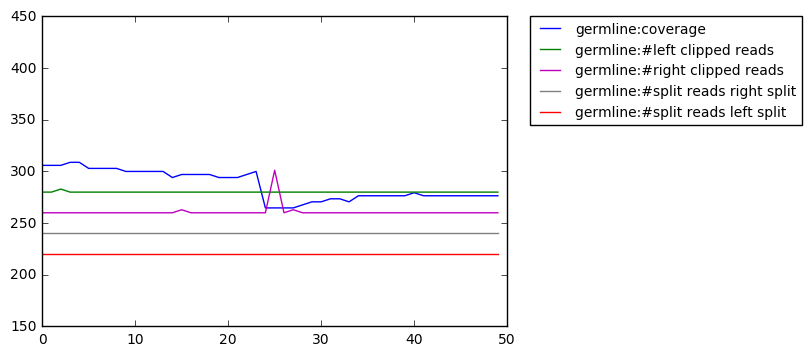

id: 3005
Nanopore: noSV . DeepSV: DEL_end


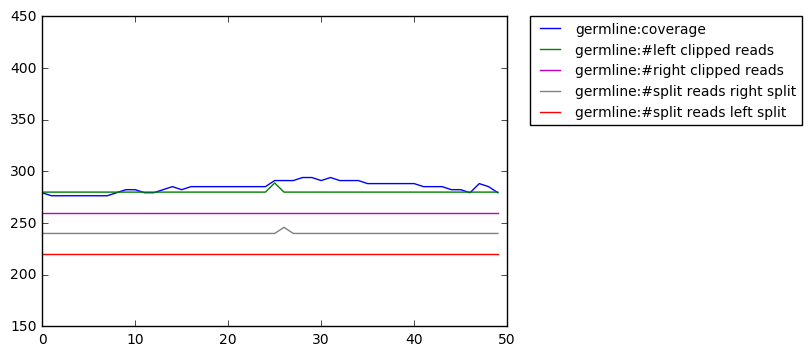

id: 3010
Nanopore: noSV . DeepSV: DEL_start


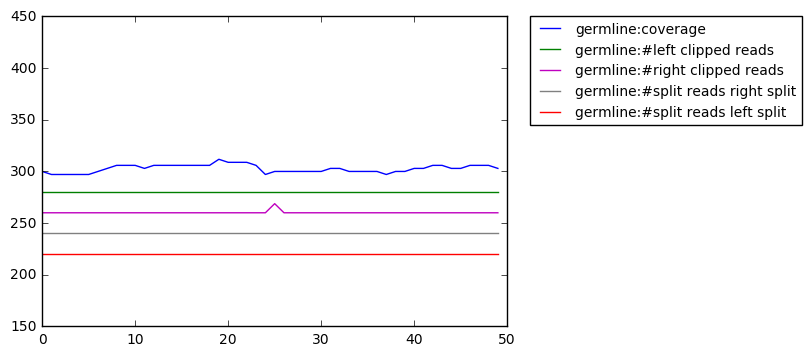

id: 3015
Nanopore: noSV . DeepSV: DEL_start


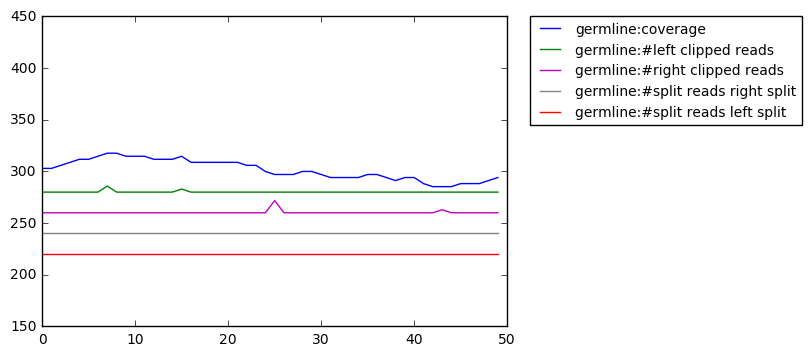

id: 3020
Nanopore: noSV . DeepSV: DEL_start


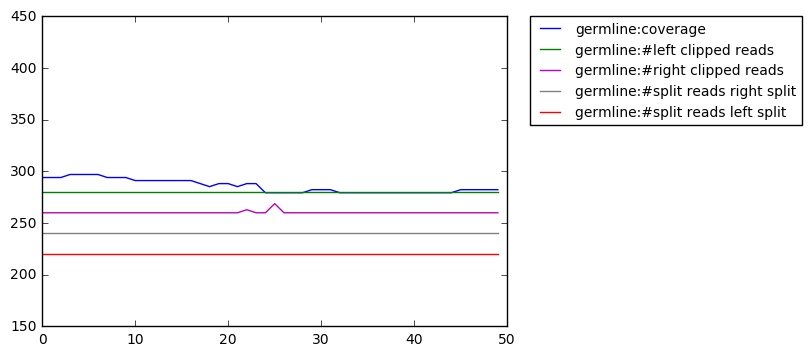

id: 3025
Nanopore: noSV . DeepSV: noSV


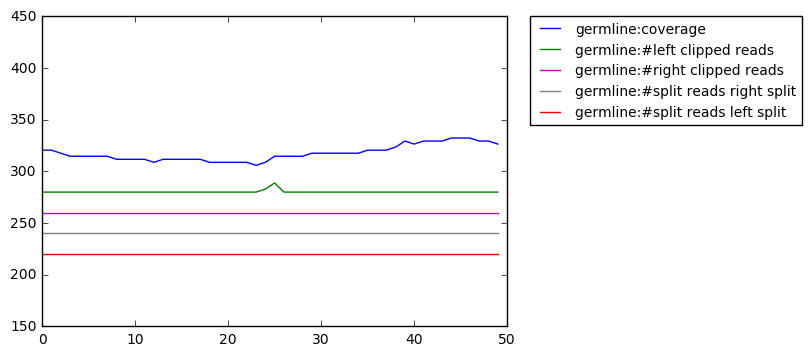

id: 3030
Nanopore: noSV . DeepSV: DEL_start


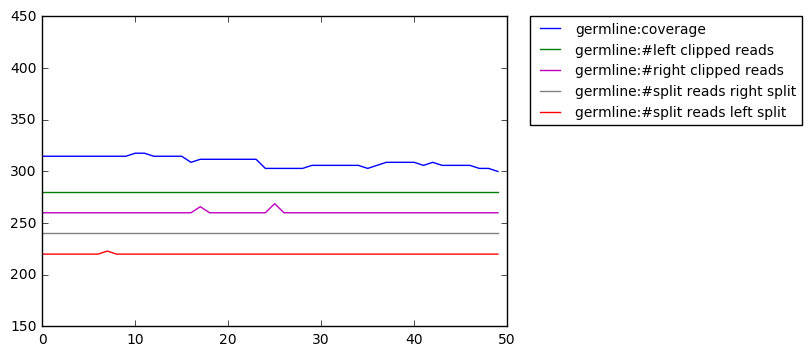

id: 3035
Nanopore: noSV . DeepSV: DEL_end


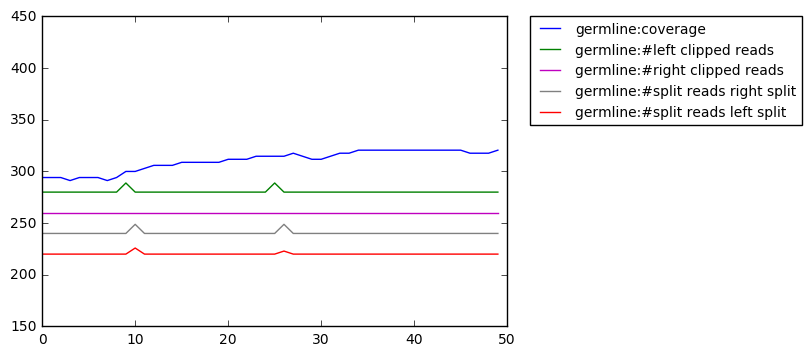

id: 3040
Nanopore: noSV . DeepSV: DEL_start


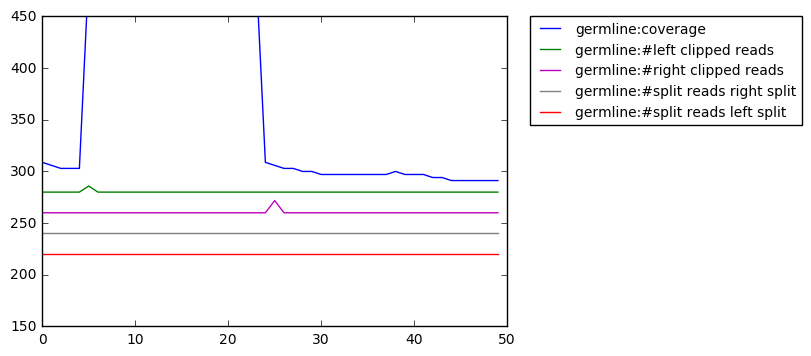

id: 3045
Nanopore: noSV . DeepSV: DEL_end


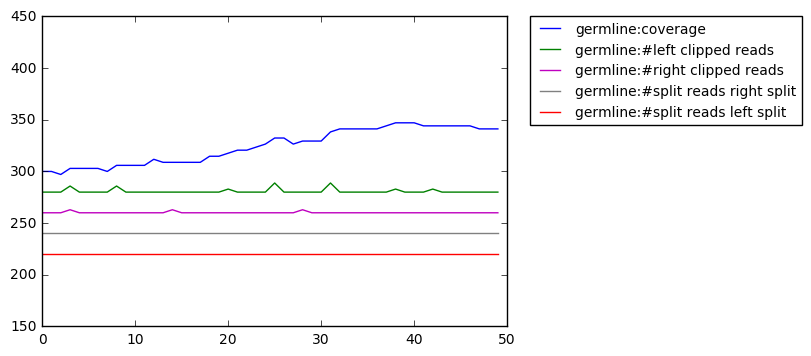

id: 3050
Nanopore: noSV . DeepSV: noSV


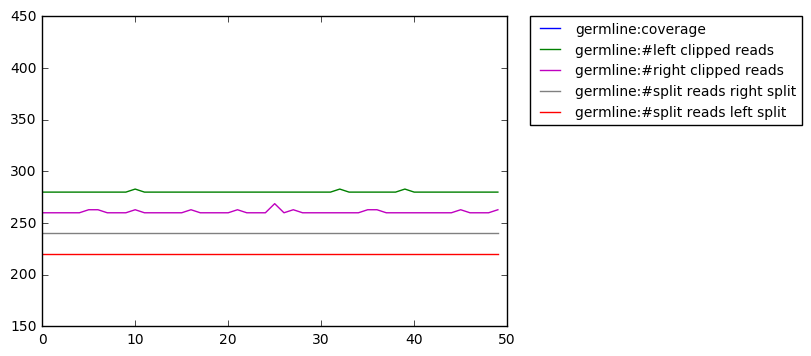

id: 3055
Nanopore: noSV . DeepSV: DEL_end


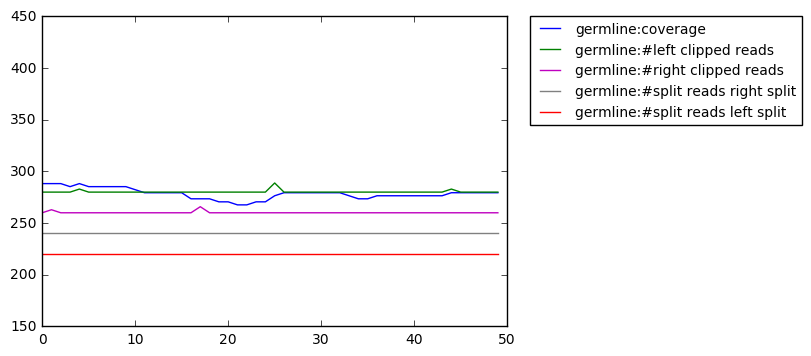

id: 3060
Nanopore: noSV . DeepSV: DEL_start


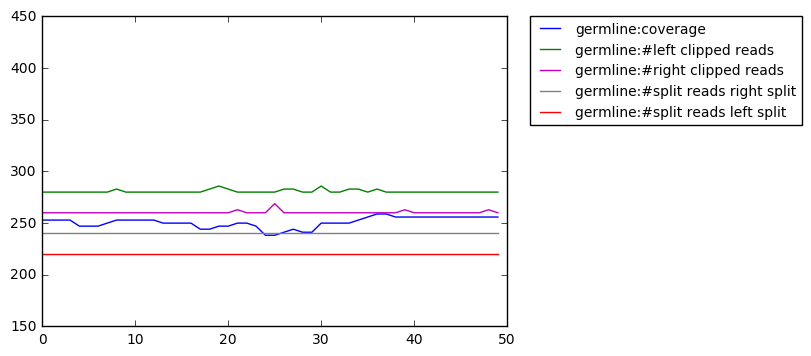

id: 3065
Nanopore: noSV . DeepSV: DEL_end


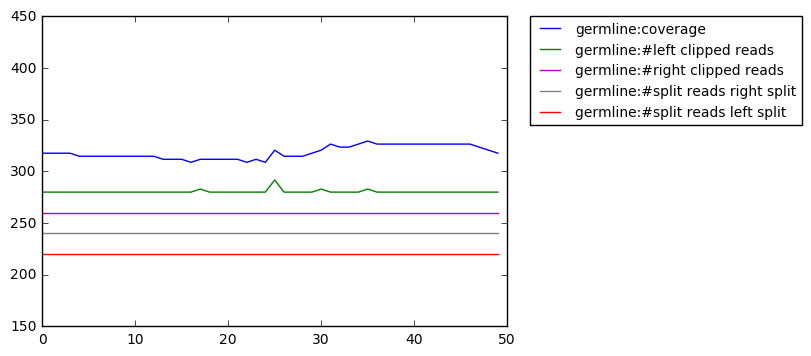

id: 3070
Nanopore: noSV . DeepSV: DEL_end


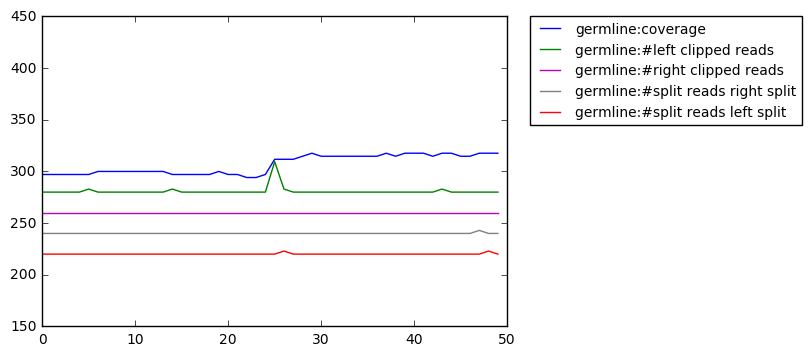

id: 3075
Nanopore: noSV . DeepSV: DEL_end


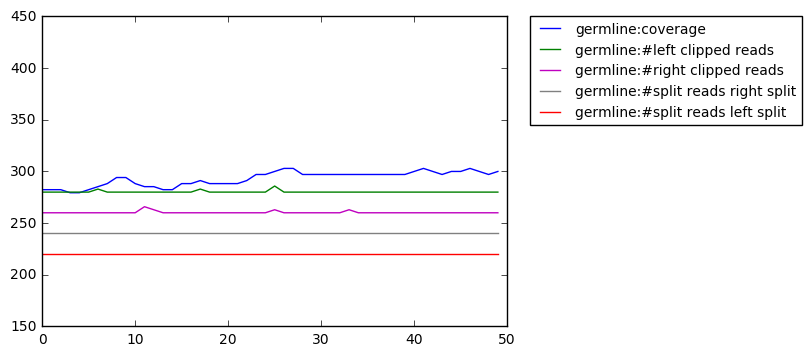

id: 3080
Nanopore: noSV . DeepSV: DEL_start


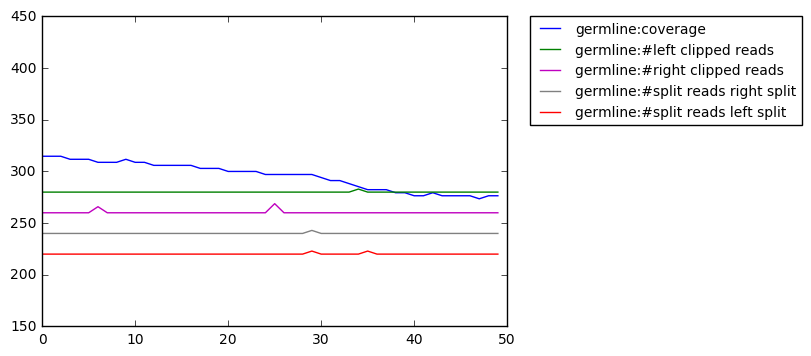

id: 3085
Nanopore: noSV . DeepSV: DEL_end


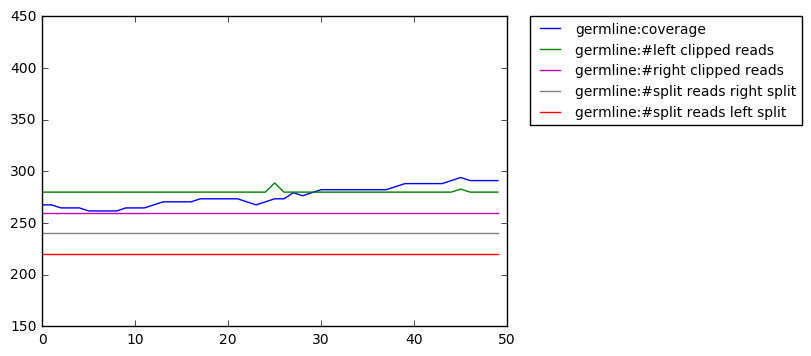

id: 3090
Nanopore: noSV . DeepSV: DEL_start


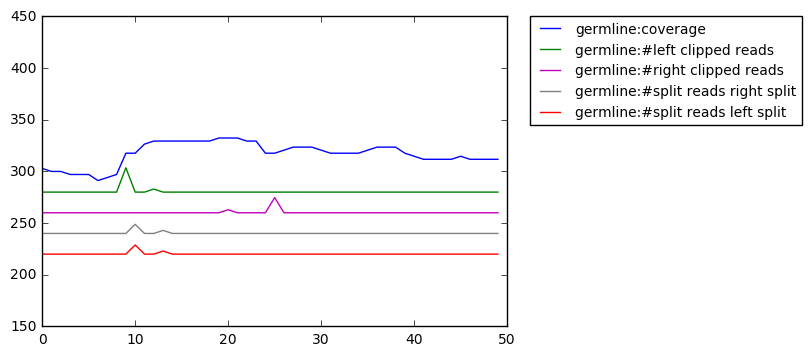

id: 3095
Nanopore: noSV . DeepSV: DEL_start


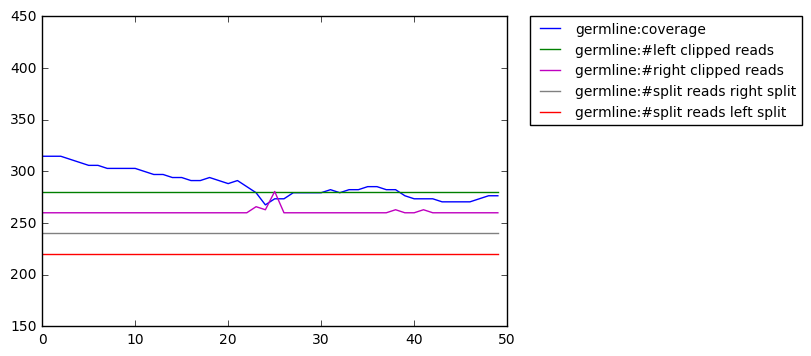

id: 3100
Nanopore: noSV . DeepSV: DEL_start


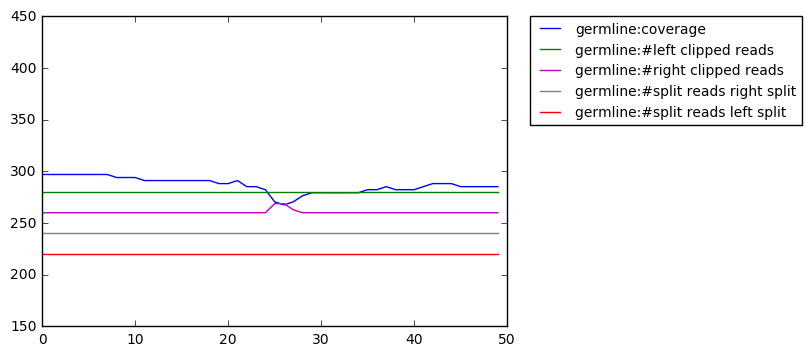

id: 3105
Nanopore: noSV . DeepSV: DEL_end


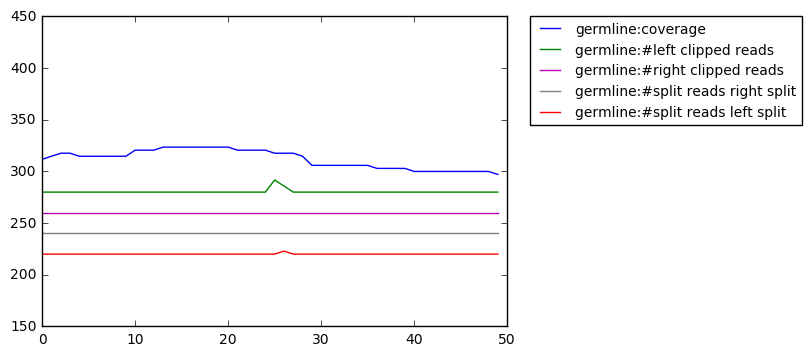

id: 3110
Nanopore: noSV . DeepSV: noSV


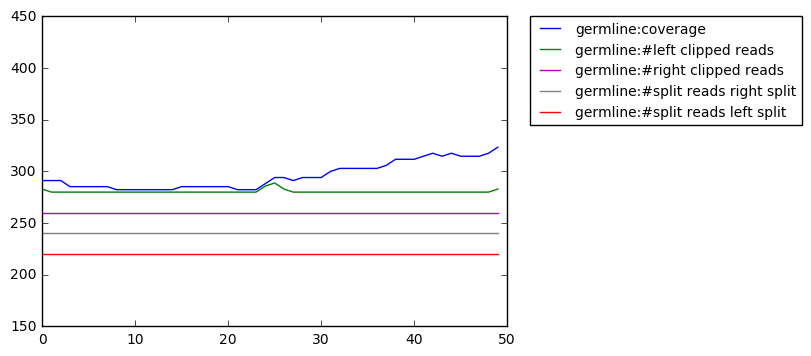

id: 3115
Nanopore: noSV . DeepSV: DEL_end


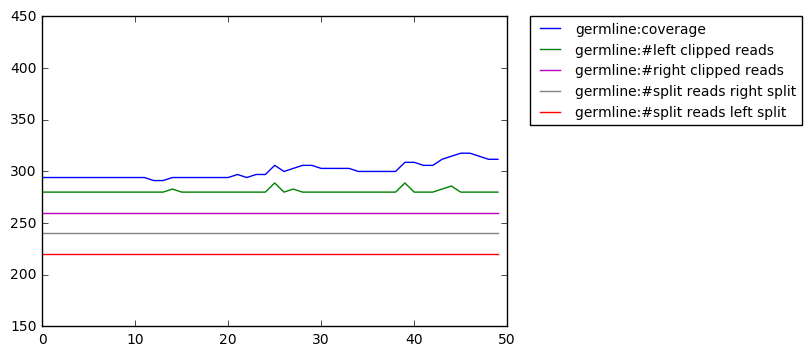

id: 3120
Nanopore: noSV . DeepSV: DEL_end


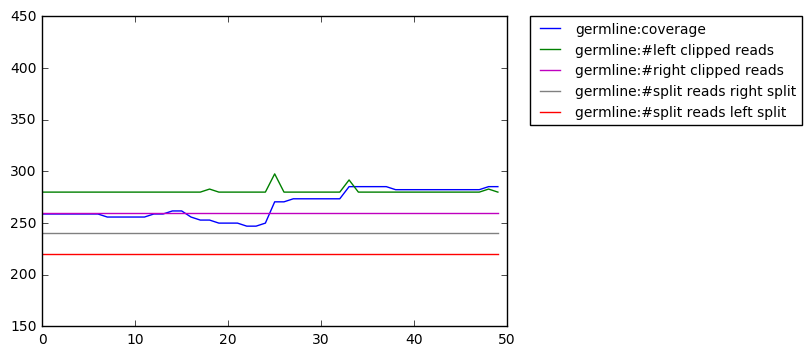

id: 3125
Nanopore: noSV . DeepSV: DEL_start


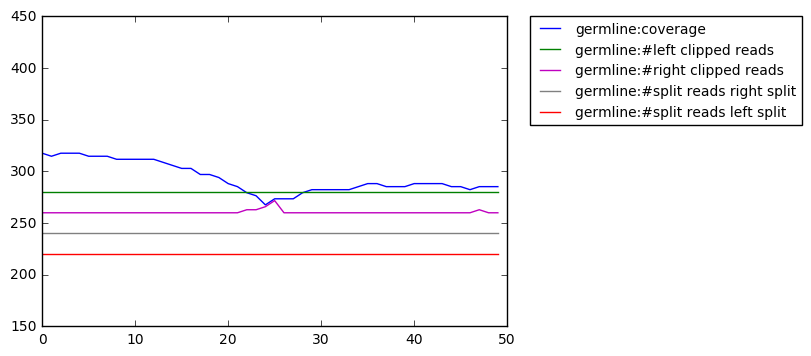

id: 3130
Nanopore: noSV . DeepSV: DEL_end


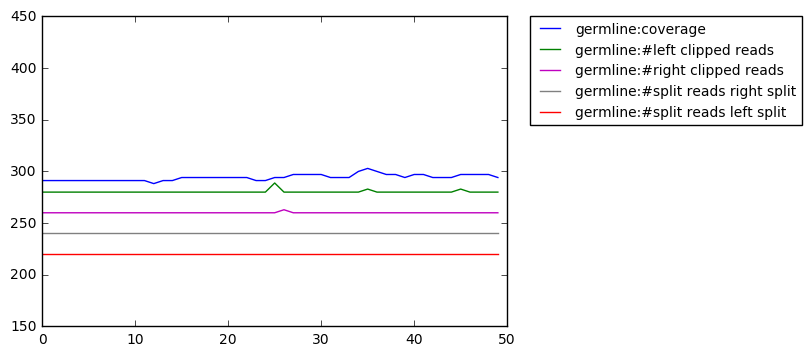

id: 3135
Nanopore: noSV . DeepSV: DEL_start


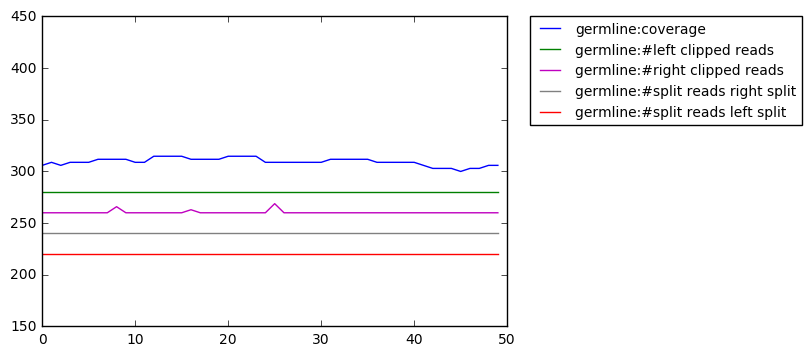

id: 3140
Nanopore: noSV . DeepSV: DEL_start


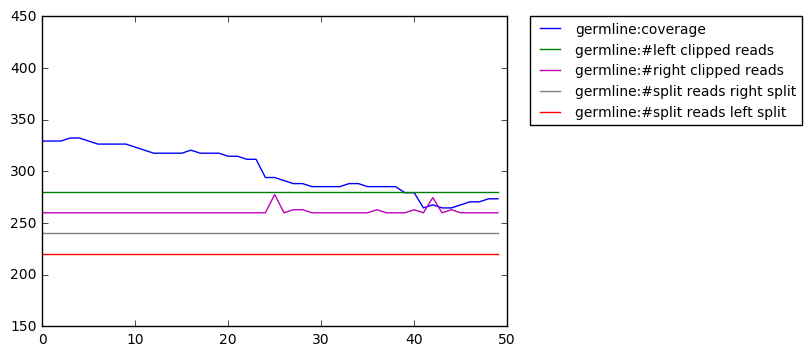

id: 3145
Nanopore: noSV . DeepSV: DEL_start


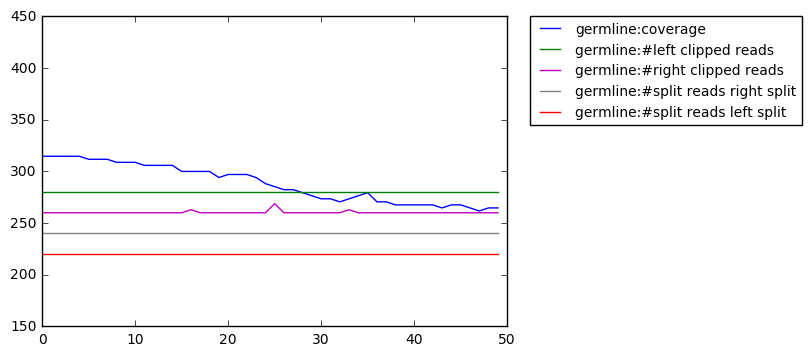

id: 3150
Nanopore: noSV . DeepSV: DEL_end


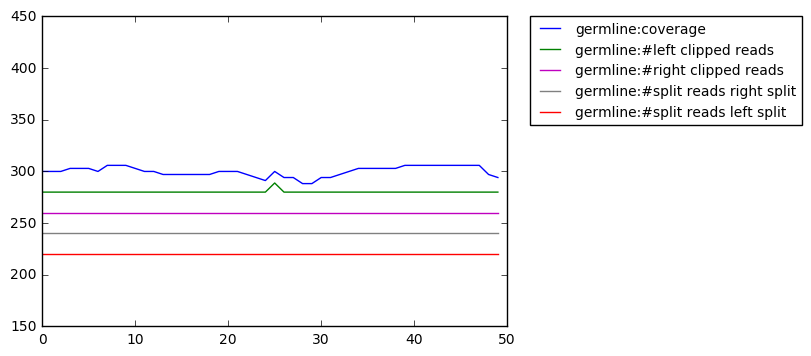

id: 3155
Nanopore: noSV . DeepSV: DEL_start


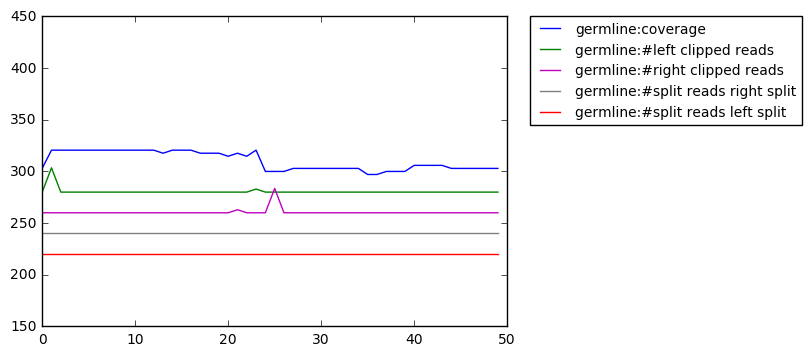

id: 3160
Nanopore: noSV . DeepSV: DEL_start


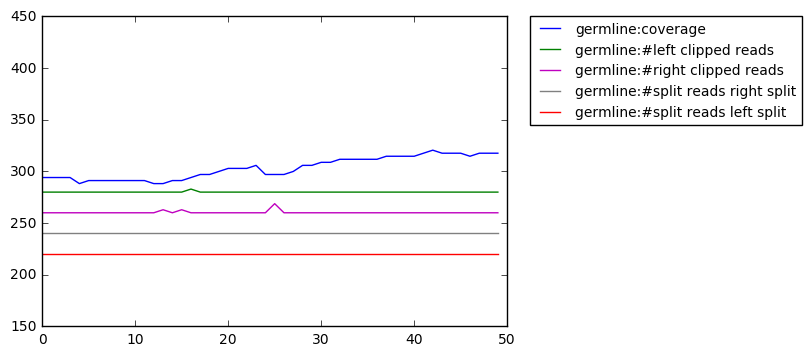

id: 3165
Nanopore: noSV . DeepSV: DEL_end


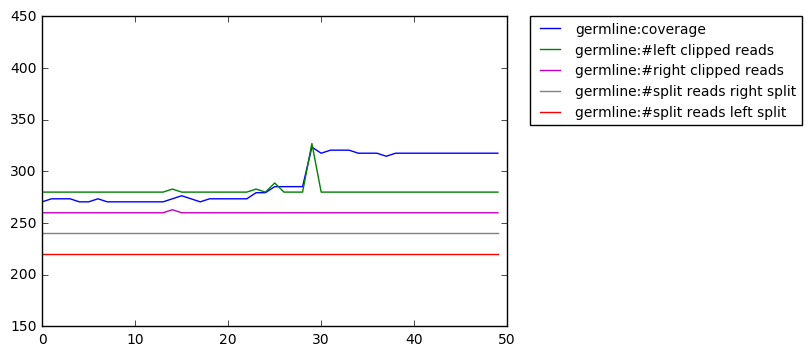

id: 3170
Nanopore: noSV . DeepSV: DEL_end


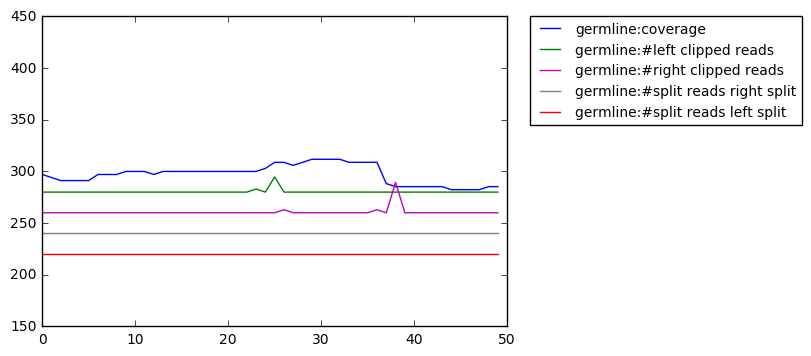

id: 3175
Nanopore: noSV . DeepSV: DEL_end


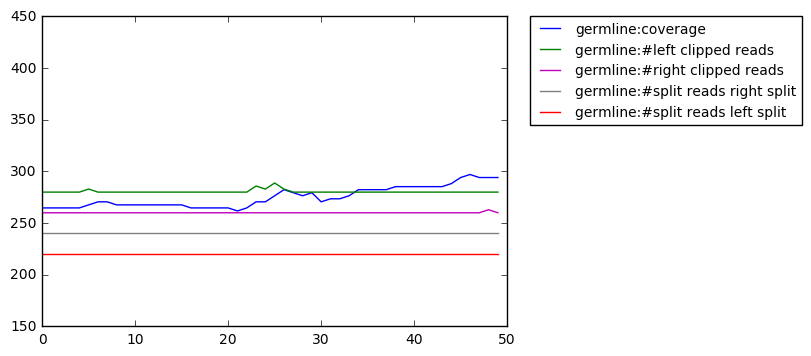

id: 3180
Nanopore: noSV . DeepSV: DEL_start


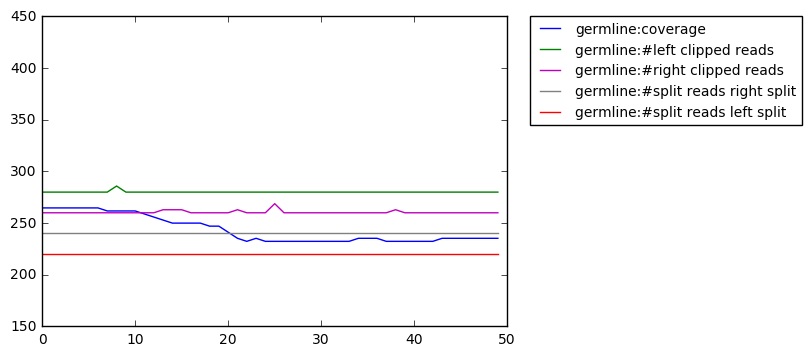

id: 3185
Nanopore: noSV . DeepSV: DEL_end


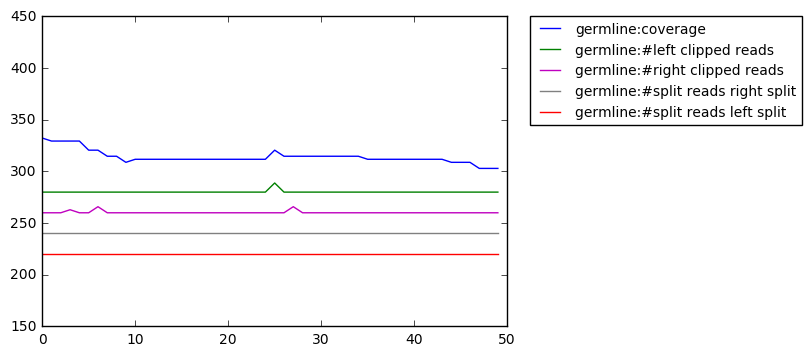

id: 3190
Nanopore: noSV . DeepSV: noSV


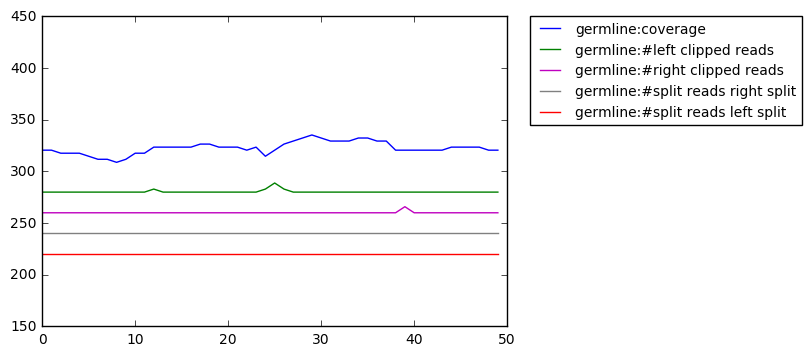

id: 3195
Nanopore: noSV . DeepSV: DEL_end


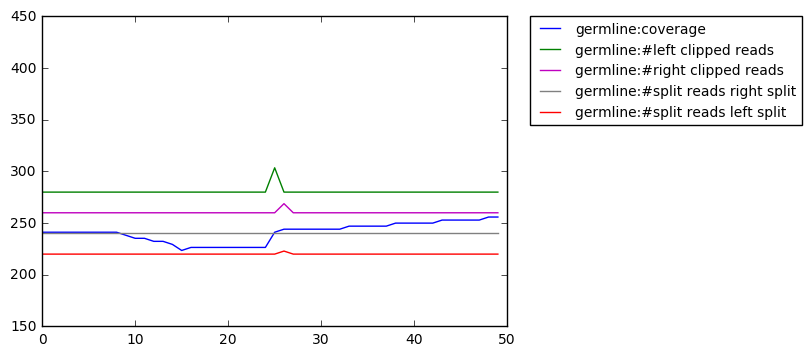

id: 3200
Nanopore: noSV . DeepSV: DEL_start


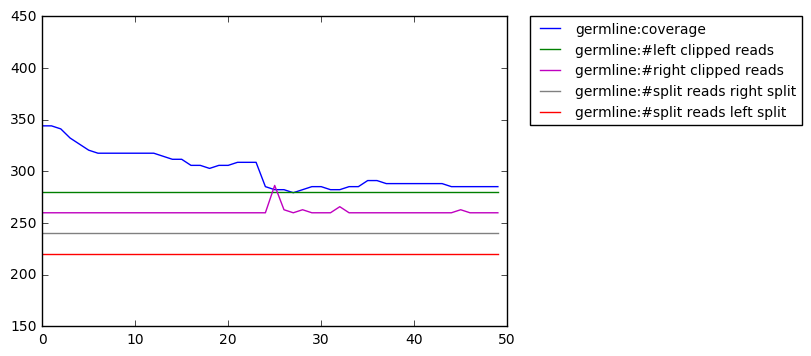

id: 3205
Nanopore: noSV . DeepSV: DEL_end


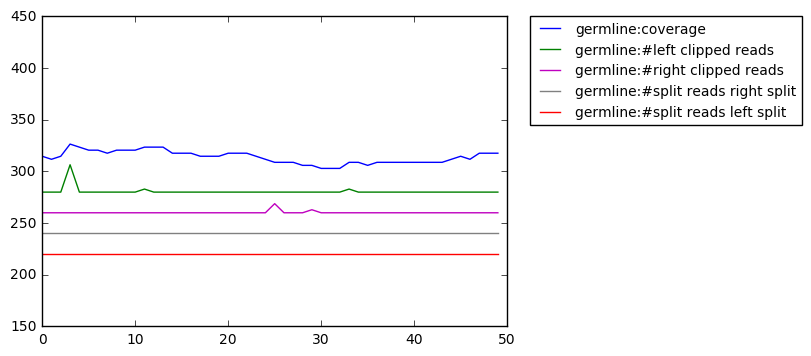

id: 3210
Nanopore: noSV . DeepSV: DEL_end


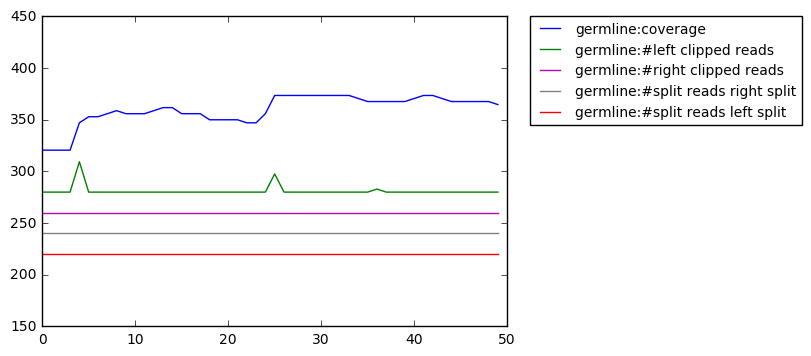

id: 3215
Nanopore: noSV . DeepSV: DEL_start


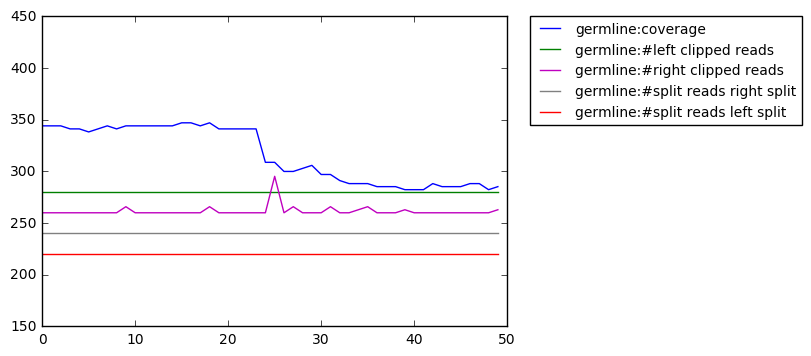

id: 3220
Nanopore: noSV . DeepSV: DEL_start


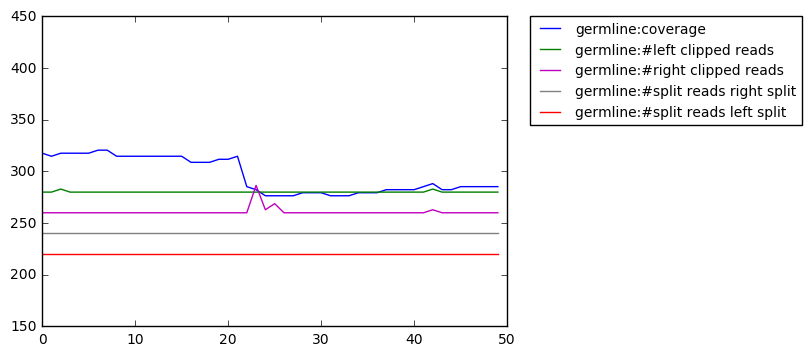

id: 3225
Nanopore: noSV . DeepSV: DEL_end


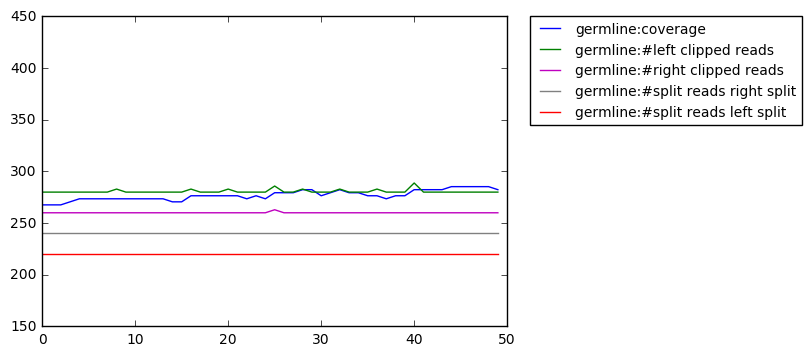

id: 3230
Nanopore: noSV . DeepSV: DEL_end


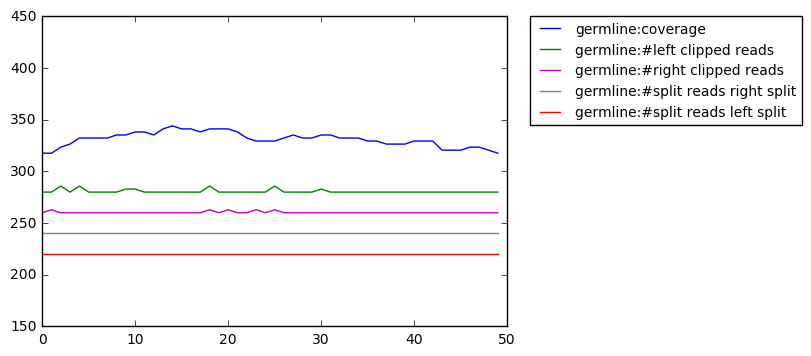

id: 3235
Nanopore: noSV . DeepSV: DEL_start


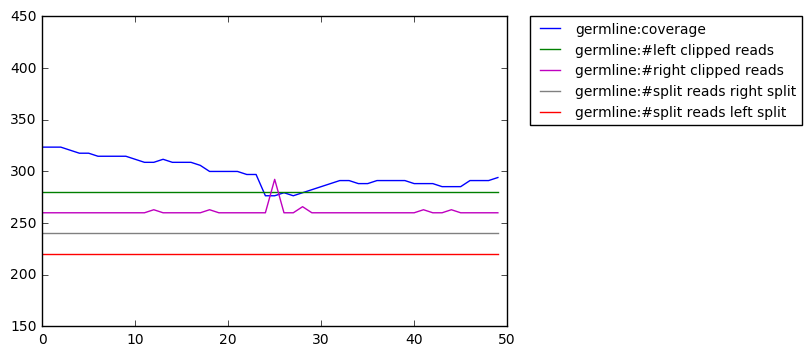

id: 3240
Nanopore: noSV . DeepSV: DEL_end


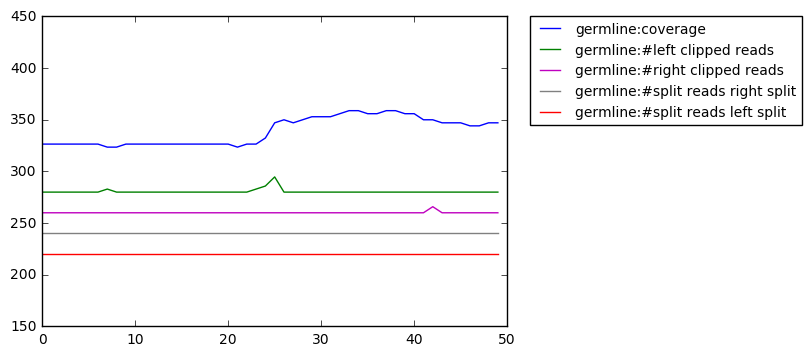

id: 3245
Nanopore: noSV . DeepSV: DEL_end


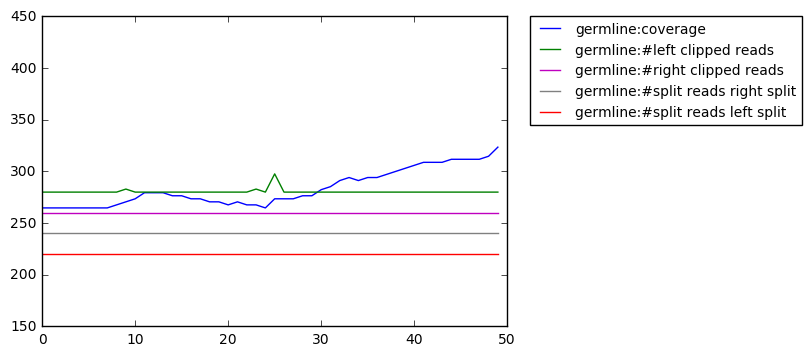

id: 3250
Nanopore: noSV . DeepSV: DEL_end


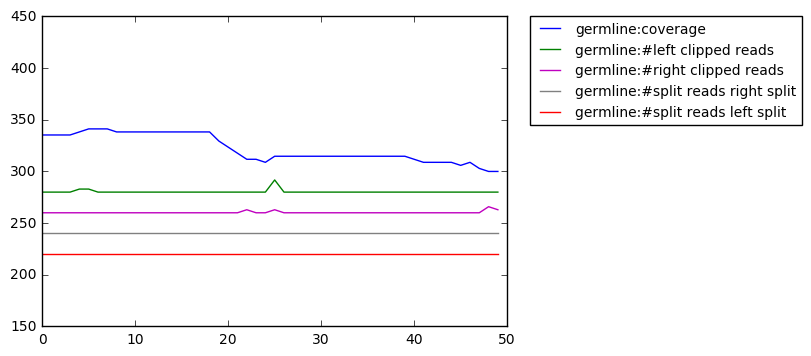

id: 3255
Nanopore: noSV . DeepSV: DEL_end


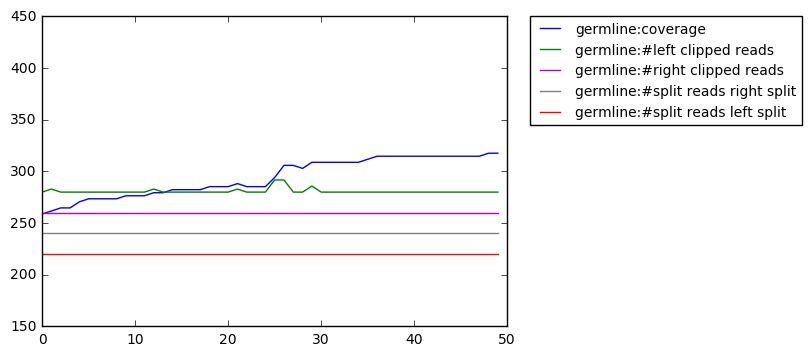

id: 3260
Nanopore: noSV . DeepSV: DEL_start


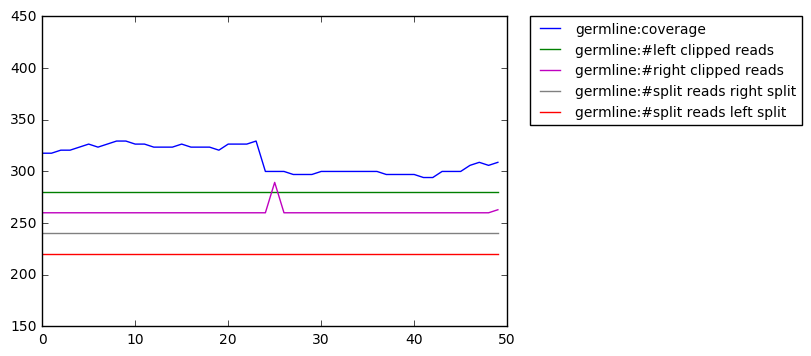

id: 3265
Nanopore: noSV . DeepSV: DEL_end


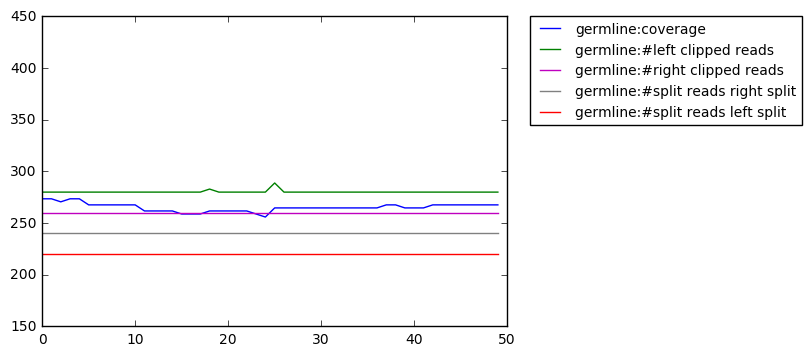

id: 3270
Nanopore: noSV . DeepSV: DEL_start


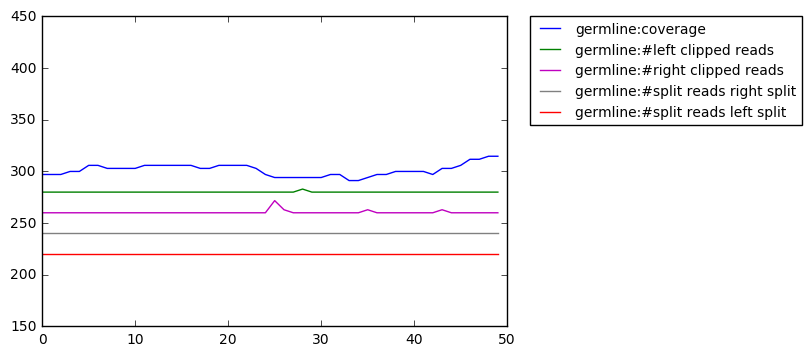

id: 3275
Nanopore: noSV . DeepSV: DEL_end


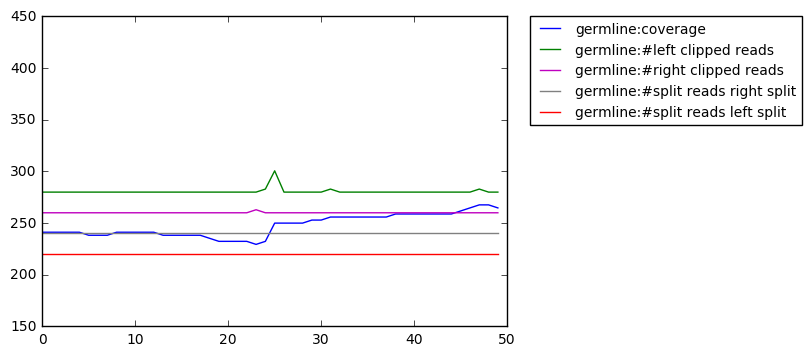

In [73]:
n_windows = 280
start_window = 3000
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [65]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

50


## Prepare the labels in McFly format

In [47]:
mapclasses = {'DEL_start': 1, 'DEL_end': 0,  'noSV': 2}
print(mapclasses)

{'noSV': 2, 'DEL_start': 1, 'DEL_end': 0}


In [52]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [53]:
y_test_binary

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [54]:
y_val_binary

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

In [55]:
X_train.shape

(8000, 50, 5)

## Use trained neural network on synthetic data

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

## Reload the trained model

In [57]:
import os
from keras.models import load_model
model_path = os.path.join('F:/CNN/notebooks/', 'Gtcg_20_07_18')
model_reloaded = load_model(model_path)

## Inspect model predictions on test data

In [58]:

model = model_reloaded
datasize = X_test.shape[0]
probs = model.predict_proba(X_test[:datasize,:,:],batch_size=1)

## Columns are predicted labels by DeepSV, rows are nanopore labels

In [59]:
mapclasses = {'DEL_end': 0, 'DEL_start': 1, 'noSV': 2}
dict=mapclasses
dict_sorted = sorted(dict.items(), key=lambda x: x[1])
dict_sorted

[('DEL_end', 0), ('DEL_start', 1), ('noSV', 2)]

In [60]:
labels = [i[0] for i in dict_sorted]

In [61]:
import pandas as pd
predicted = probs.argmax(axis=1)
y_index = y_test_binary.argmax(axis=1)
confusion_matrix = pd.crosstab(pd.Series(y_index), pd.Series(predicted))
confusion_matrix.index = [labels[i] for i in confusion_matrix.index]
confusion_matrix.columns = [labels[i] for i in confusion_matrix.columns]
confusion_matrix.reindex(columns=[l for l in labels], fill_value=0)
confusion_matrix

DEL_end  DEL_start  noSV
DEL_end        370        266    27
DEL_start      207        375    47
noSV           918        932   150

## Test best current model on testset

### Overall accuracy on the test set:

In [62]:
%%time
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [3.561698209037178, 0.27187120292973982]
Wall time: 418 ms
